# Trabalho Final da Disciplina Organização do Conhecimento (MAI715)


## Análise em datasets de nanopublicações quanto à qualidade dos dados de direitos autorais e licenciamento

Programa de Pós-graduação em Informática

Universidade Federal do Rio de Janeiro (UFRJ) - Rio de Janeiro, RJ - Brasil

Trabalho da disciplina: Organização do Conhecimento (MAI715)

Professora: Giseli Rabello Lopes [giseli@dcc.ufrj.br ]

Aluno: Massao Oliveira Iwanaga [massaoiwanaga@ufrj.br]

<h2>Preâmbulo</h2>

Para rodar as análises a seguir, você precisa instalar e disponibilizar os endpoints SPARQL usando alguma triple store (Graph DB, Virtuoso, Jena Fuseki) e carregando os datasets. Em seguida é preciso atualizar os links dos endpoints na seção apropriada aqui contida.

<h3>Links com os Datasets de Nanopublicações Usados</h3>

- [neXtProt 1900_2000](https://sourceforge.net/projects/nextprot2rdf/files/data/nextprot/releases/2014-09/nextprot_19001_20000.tar.gz/download)

- [DisGetNET 4.0](http://rdf.disgenet.org/download/v4.0.0/nanopublications_v4.0.0.0.trig.gz)

- [WikiPathways 20201210](https://github.com/peta-pico/wikipathways-nanopubs/blob/master/output/combined/20201210_full.trig.gz)

- [LIDDI V1.01](https://ckannet-storage.commondatastorage.googleapis.com/2015-07-20T06:50:47.760Z/liddi-v1-01-trig.gz)

- [OpenBell Large Corpus 1.0](https://github.com/tkuhn/bel2nanopub/releases/download/v1.0/bel-corpora-output.zip)

É importante ressaltar que, por limitação da capacidade de processamento do computador pessoal e de armazenamento da versão grátis do Graph DB, os datasets foram recortados, da seguinte forma:

- [neXtProt 1900_2000]: Originalmente: 220.916 nanopublicações. Recorte deste experimento: mantendo as 68.746 primeiras nanopublicações.

- [DisGetNET 4.0]: Originalmente: 1.414.902 nanopublicações. Recorte deste experimento: mantendo as 8.235 primeiras nanopublicações.

- [WikiPathways 20201210]: Mantido com a quantidade original de nanopublicações (16.247).

- [LIDDI V1.01]: Recorte deste experimento: mantendo as 88.087 primeiras nanopublicações.

- [OpenBell Large Corpus 1.0]: Recorte deste experimento: mantendo as 48.674 primeiras nanopublicações.

## 1) Importação de Bibliotecas ##

In [466]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import csv
from SPARQLWrapper import SPARQLWrapper, JSON, CSV, XML
import statistics
import numpy as np
from xml.dom.minidom import parse, parseString

## 2) Configurando os Endpoints SPARQL ##

In [467]:
#Definindo o endpoint SPARQL DisGeNet e a função que executará as queries
dbSparqlDGN = SPARQLWrapper("http://DESKTOP-J4GEQRH:7200/repositories/disgenet")
dbSparqlDGN.setReturnFormat(JSON)

def queryDisGeNET(query):
    dbSparqlDGN.setQuery(query)
    results = dbSparqlDGN.queryAndConvert()
    return results

#Definindo o endpoint SPARQL NeXtProt e a função que executará as queries
dbSparqlNxt = SPARQLWrapper("http://DESKTOP-J4GEQRH:7200/repositories/nextprot")
dbSparqlNxt.setReturnFormat(JSON)

def queryNeXtProt(query):
    dbSparqlNxt.setQuery(query)
    results = dbSparqlNxt.queryAndConvert()
    return results

#Definindo o endpoint SPARQL WikiPathways e a função que executará as queries
dbSparqlWP = SPARQLWrapper("http://DESKTOP-J4GEQRH:7200/repositories/wikipathways")
dbSparqlWP.setReturnFormat(JSON)

def queryWP(query):
    dbSparqlWP.setQuery(query)
    results = dbSparqlWP.queryAndConvert()
    return results

#Definindo o endpoint SPARQL OpenBell e a função que executará as queries
dbSparqlOBL = SPARQLWrapper("http://DESKTOP-J4GEQRH:7200/repositories/belcorpora")
dbSparqlOBL.setReturnFormat(JSON)

def queryOpenBellLarge(query):
    dbSparqlOBL.setQuery(query)
    results = dbSparqlOBL.queryAndConvert()
    return results

#Definindo o endpoint SPARQL LIDDI e a função que executará as queries
dbSparqlLIDDI = SPARQLWrapper("http://DESKTOP-J4GEQRH:7200/repositories/LIDDI")
dbSparqlLIDDI.setReturnFormat(JSON)

def queryLIDDI(query):
    dbSparqlLIDDI.setQuery(query)
    results = dbSparqlLIDDI.queryAndConvert()
    return results

## 3) Definição de funções auxiliares para trabalhar com as queries

In [468]:
#Definindo a função para receber o array com o resultado da contagem (count)
def get_array(results):
    """
    Extract the count result from the JSON format
    """
    array = []
    for result in results["results"]["bindings"]:
        if((result["count"]["value"]).isnumeric()):
            value = int(result["count"]["value"])
            array.append(value)
    array.sort()
    return array

#Definindo a função para receber o array com o resultado de "rights"
def get_array2(results):
    """
    Extract the count result from the JSON format
    """
    array = []
    for result in results["results"]["bindings"]:
        if((result["count"]["value"]).isnumeric()):
            value = int(result["count"]["value"])
            array.append([result["rights"]["value"], value])
    array.sort()
    return array

#Definindo a função para receber o array com o resultado de "rights", agrupando e contando
def get_array3(results):
    """
    Extract the count result from the JSON format
    """
    array = []
    array2 = []
    for result in results["results"]["bindings"]:
        array2.append(result["rights"]["value"])
    array.append(array2)
    array2 = []
    for result in results["results"]["bindings"]:
        if((result["count"]["value"]).isnumeric()):
            value = int(result["count"]["value"])
            array2.append(value)
    array.append(array2)
    return array

#Definindo a função para receber o array com o resultado de "licence", agrupando e contando
def get_array4(results):
    """
    Extract the count result from the JSON format
    """
    array = []
    array2 = []
    for result in results["results"]["bindings"]:
        array2.append(result["licence"]["value"])
    array.append(array2)
    array2 = []
    for result in results["results"]["bindings"]:
        if((result["count"]["value"]).isnumeric()):
            value = int(result["count"]["value"])
            array2.append(value)
    array.append(array2)
    #array.sort()
    return array

#Definindo a função para receber o array com o resultado de "rightsHolder", agrupando e contando
def get_array5(results):
    """
    Extract the count result from the JSON format
    """
    array = []
    array2 = []
    for result in results["results"]["bindings"]:
        array2.append(result["rightsHolder"]["value"])
    array.append(array2)
    array2 = []
    for result in results["results"]["bindings"]:
        if((result["count"]["value"]).isnumeric()):
            value = int(result["count"]["value"])
            array2.append(value)
    array.append(array2)
    #array.sort()
    return array

def average(list):
    return sum(list) / float(len(list)) 

## Análise do NeXtProt ##

### [NeXtProt](https://www.nextprot.org/) ###

neXtProt é uma plataforma de conhecimento on-line sobre proteínas humanas. Ele se dedica a ser um recurso abrangente que fornece uma variedade de tipos de informações sobre proteínas humanas, como sua função, localização subcelular, expressão, interações e papel nas doenças.

In [151]:
# A query SPARQL a seguir realiza a contagem de triplas de cada grafo HEAD em cada nanopublicação
query = """
prefix np: <http://www.nanopub.org/nschema#>
select (count(?h) as ?count) 
where {
      graph ?h {
        ?_np_iri a np:Nanopublication ;
                  ?p ?o .
       }
    }
GROUP BY ?h
"""

results = queryNeXtProt(query)
nxtHeadTriples = get_array(results)

In [155]:
# A query SPARQL a seguir realiza a contagem de triplas de cada grafo ASSERTION em cada nanopublicação
query = """
prefix np: <http://www.nanopub.org/nschema#>
    select (count(*) as ?count)
    where {
      graph ?h {
        ?_np_iri a np:Nanopublication ;
          np:hasAssertion ?a .
      }
      graph ?a {?s ?p ?o}
    } 
    GROUP BY ?a
"""

results = queryNeXtProt(query)
nxtAssertionTriples = get_array(results)

In [156]:
# A query SPARQL a seguir realiza a contagem de triplas de cada grafo PROVENANCE em cada nanopublicação
query = """
prefix np: <http://www.nanopub.org/nschema#>

    select (count(*) as ?count) where {
      graph ?h {
        ?_np_iri a np:Nanopublication ;
          np:hasProvenance ?prov .
      }
      graph ?prov {?s ?p ?o}
    } 
    GROUP BY ?prov
"""

results = queryNeXtProt(query)
nxtProvenanceTriples = get_array(results)

In [157]:
# A query SPARQL a seguir realiza a contagem de triplas de cada grafo PUBLICATION INFO em cada nanopublicação
query = """
prefix np: <http://www.nanopub.org/nschema#>
    select (count(*) as ?count) where {
      graph ?h {
        ?_np_iri a np:Nanopublication ;
          np:hasPublicationInfo ?pubInfo .
      }
      graph ?pubInfo {?s ?p ?o}
    } 
    GROUP BY ?pubInfo
"""

results = queryNeXtProt(query)
nxtPubInfoTriples = get_array(results)

In [158]:
# Armazenando o resultado em um arquivo CSV:
with open('distributionNeXtProt.csv', mode='w') as csv_file:
    fieldnames = ['Grafos', 'Triplas']
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    writer.writerow(['Grafos', 'Triplas'])
    
    # Grafos HEAD
    for t in nxtHeadTriples:
        writer.writerow(['Head', t])
    
    # Grafos ASSERTION
    for t in nxtAssertionTriples:
        writer.writerow(['Assertion', t])
        
    # Grafos PROVENANCE
    for t in nxtProvenanceTriples:
        writer.writerow(['Provenance', t])
        
    # Grafos PUBLICATION INFO
    for t in nxtPubInfoTriples:
        writer.writerow(['PublicationInfo', t])

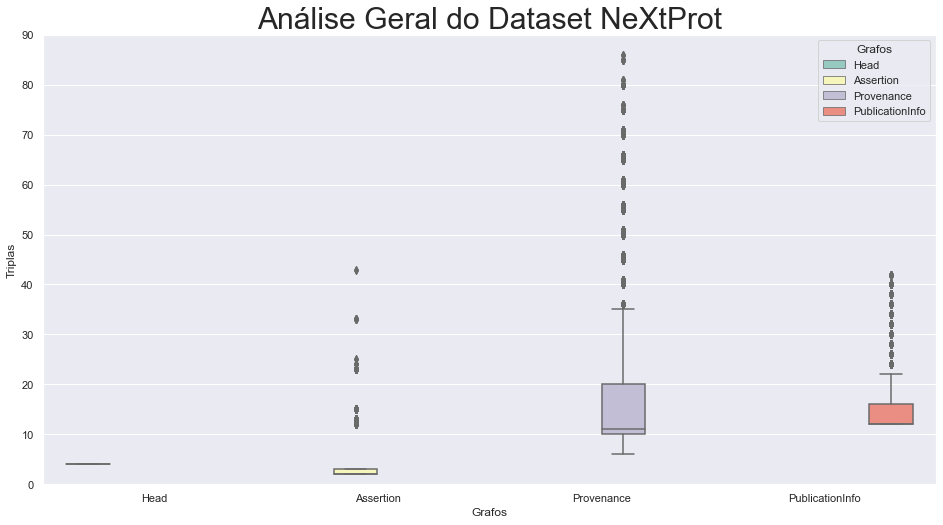

In [159]:
dataNeXt = pd.read_csv('distributionNeXtProt.csv')

sns.set(style="whitegrid"),
sns.set(rc={'figure.figsize':(16,8.27)}),
ax = sns.boxplot(x="Grafos", y="Triplas", hue="Grafos", data=dataNeXt, palette="Set3")
ax.axes.set_title("Análise Geral do Dataset NeXtProt",fontsize=30)
ax.set_ylim(0, 90);

In [469]:
# Contagem de nanopublicações usando dcterms:rights no grafo Publication Info
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select (count(*) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np (dcterms:rights) ?rights .
  }
}
"""

results = queryNeXtProt(query)
nxtNumRights = get_array(results)
print(nxtNumRights)

[68746]


In [470]:
# Lista os diferentes objetos do predicado dcterms:rights no Publication Info e conta quantas ocorrências há
# Interessante notar que bate com o número total de nanopublicações existentes no dataset
# Indicando que todas as nanopublicações declararam o mesmo objeto para dcterms:rights
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select ?rights (count(?rights) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np (dcterms:rights) ?rights .
  }
}
GROUP BY ?rights
"""

results = queryNeXtProt(query)
nxtRightsCont = get_array3(results)
print(nxtRightsCont)
#print(results)
#nxtRightsCont_matriz = np.asmatrix(nxtRightsCont)

[['http://creativecommons.org/licenses/by/3.0/'], [68746]]


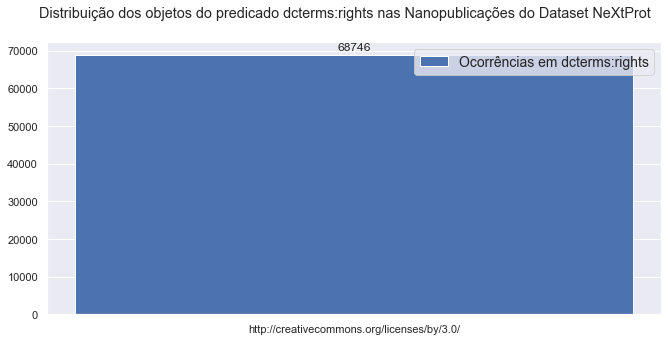

In [22]:
fig, ax = plt.subplots(figsize=(11,5)) # (width, height)
#plt.bar(nxtRightsCont[0], nxtRightsCont[1], label = 'Ocorrências do objeto')
rect = ax.bar(nxtRightsCont[0], nxtRightsCont[1], label = 'Ocorrências em dcterms:rights')
ax.legend(fontsize = 14)
ax.bar_label(rect, padding=3)
fig.suptitle("Distribuição dos objetos do predicado dcterms:rights nas Nanopublicações do Dataset NeXtProt");
plt.show()

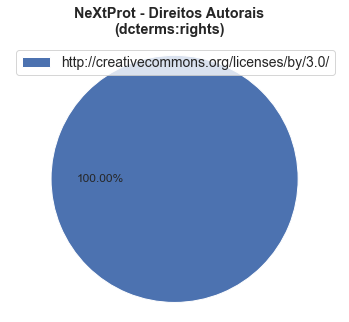

In [416]:
# Exibição do resultado em grafico de pizza
fig, ax = plt.subplots(figsize=(6, 5))
ax.pie(nxtRightsCont[1], autopct='%1.2f%%')
ax.axis('equal') # mantenha um circulo
#fig.suptitle("Distribuição dos objetos do predicado dcterms:rights nas Nanopublicações do Dataset NeXtProt");
fig.suptitle("NeXtProt - Direitos Autorais\n(dcterms:rights)", fontweight='bold');
plt.legend(nxtRightsCont[0], fontsize = 14, loc="best")
#plt.tight_layout()
plt.savefig('nxtRights.png')

In [471]:
# Contagem de nanopublicações usando dcterms:rightsHolder no grafo Publication Info
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select (count(*) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np (dcterms:rightsHolder) ?rightsHolder .
  }
}
"""

results = queryNeXtProt(query)
nxtNumRightsHolder = get_array(results)
print(nxtNumRightsHolder)

[68746]


In [472]:
# Lista os diferentes objetos do predicado dcterms:rightsHolder no Publication Info e conta quantas ocorrências há
# Interessante notar que bate com o número total de nanopublicações existentes no dataset
# Indicando que todas as nanopublicações declararam o mesmo objeto para dcterms:rightsHolder
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select ?rightsHolder (count(?rightsHolder) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np (dcterms:rightsHolder) ?rightsHolder .
  }
}
GROUP BY ?rightsHolder
"""

results = queryNeXtProt(query)
nxtRightsHolderCont = get_array5(results)
print(nxtRightsHolderCont)

[['http://nextprot.org'], [68746]]


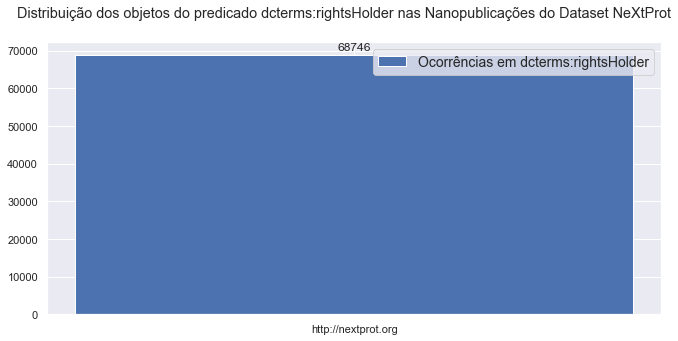

In [26]:
fig, ax = plt.subplots(figsize=(11,5)) # (width, height)
rect = ax.bar(nxtRightsHolderCont[0], nxtRightsHolderCont[1], label = 'Ocorrências em dcterms:rightsHolder')
ax.legend(fontsize = 14)
ax.bar_label(rect, padding=3)
fig.suptitle("Distribuição dos objetos do predicado dcterms:rightsHolder nas Nanopublicações do Dataset NeXtProt");
plt.show()

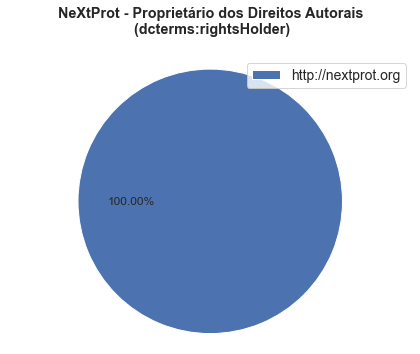

In [411]:
# Exibição do resultado em grafico de pizza
fig, ax = plt.subplots(figsize=(6, 5))
#ax.pie(nxtRightsHolderCont[1], labels=nxtRightsHolderCont[0], autopct='%1.2f%%')
ax.pie(nxtRightsHolderCont[1], autopct='%1.2f%%')
ax.axis('equal') # mantenha um circulo
#fig.suptitle("Distribuição dos objetos do predicado dcterms:rightsHolder nas Nanopublicações do Dataset NeXtProt");
fig.suptitle("NeXtProt - Proprietário dos Direitos Autorais\n (dcterms:rightsHolder)", fontweight='bold');
plt.legend(nxtRightsHolderCont[0], fontsize = 14, loc="best")
plt.tight_layout()
plt.savefig('nxtRightsHolder.png')

In [473]:
# Contagem de nanopublicações usando dcterms:licence no grafo Publication Info
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select (count(*) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np dcterms:license ?licence .
  }
}
"""

results = queryNeXtProt(query)
nxtNumLicence = get_array(results)
print(nxtNumLicence)

[0]


In [474]:
# Lista os diferentes objetos do predicado dcterms:licence no Publication Info e conta quantas ocorrências há
# Não foram retornados valores
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select ?licence (count(?licence) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np dcterms:license ?licence .
  }
}
GROUP BY ?licence
"""

results = queryNeXtProt(query)
nxtLicenceCont = get_array4(results)
print(nxtLicenceCont)

[[], []]


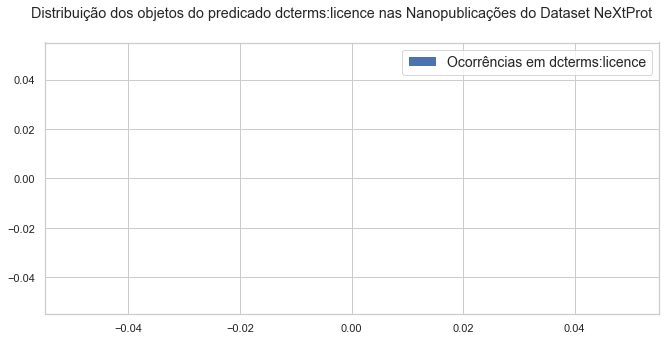

In [421]:
#Zero ocorrência
fig, ax = plt.subplots(figsize=(11,5)) # (width, height)
rect = ax.bar(nxtLicenceCont[0], nxtLicenceCont[1], label = 'Ocorrências em dcterms:licence')
ax.legend(fontsize = 14)
ax.bar_label(rect, padding=3)
fig.suptitle("Distribuição dos objetos do predicado dcterms:licence nas Nanopublicações do Dataset NeXtProt");
plt.show()

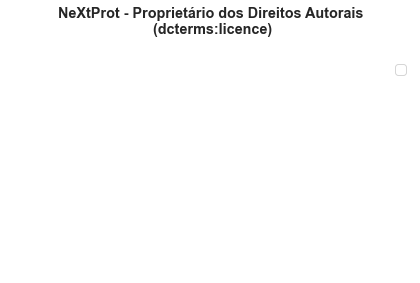

In [422]:
# Exibição do resultado em grafico de pizza
fig, ax = plt.subplots(figsize=(6, 4))
#ax.pie(nxtRightsHolderCont[1], labels=nxtRightsHolderCont[0], autopct='%1.2f%%')
ax.pie(nxtLicenceCont[1], autopct='%1.2f%%', normalize=True)
ax.axis('equal') # mantenha um circulo
#fig.suptitle("Distribuição dos objetos do predicado dcterms:licence nas Nanopublicações do Dataset NeXtProt");
fig.suptitle("NeXtProt - Proprietário dos Direitos Autorais\n (dcterms:licence)", fontweight='bold');
plt.legend(nxtLicenceCont[0], fontsize = 14, loc="best")
plt.tight_layout()
plt.savefig('nxtLicence.png')

## Análise do WikiPathways ##

### [WikiPathways](https://www.wikipathways.org)

O WikiPathways foi estabelecido para facilitar a contribuição e manutenção de informações sobre caminhos pela comunidade biológica. WikiPathways é uma plataforma aberta e colaborativa dedicada à curadoria de vias biológicas. Cada caminho no WikiPathways tem uma página wiki dedicada, exibindo o diagrama atual, descrição, referências, opções de download, histórico de versões e listas de genes e proteínas de componentes. Qualquer caminho pode ser editado a partir de sua página wiki ativando um editor de caminho embutido.

[Portal da Web Semântica WikiPathways] (https://www.wikipathways.org/index.php/Portal:Semantic_Web) descreve os recursos da Web Semântica dos bancos de dados WikiPathways, como a tradução Resource Description Framework (RDF), a ontologia e as novas nanopublicações.

Está em uso no experimento a versão 2017 da nanopublicação da Wikipathways. O autor Tobias Kuhn converteu o banco de dados de wikipathways em nanopublicação em 5 de outubro de 2017.

In [32]:
# A query SPARQL a seguir realiza a contagem de triplas de cada grafo HEAD em cada nanopublicação
query = """
prefix np: <http://www.nanopub.org/nschema#>
select (count(?h) as ?count)
where {
      graph ?h {
        ?_np_iri a np:Nanopublication ;
                  ?p ?o .
       }
    }
GROUP BY ?h
"""

results = queryWP(query)
wpHeadTriples = get_array(results)

In [33]:
# A query SPARQL a seguir realiza a contagem de triplas de cada grafo ASSERTION em cada nanopublicação
query = """
prefix np: <http://www.nanopub.org/nschema#>

    select (count(*) as ?count)
    where {
      graph ?h {
        ?_np_iri a np:Nanopublication ;
          np:hasAssertion ?a .
      }
      graph ?a {?s ?p ?o}
    } 
    GROUP BY ?a
"""

results = queryWP(query)
wpAssertionTriples = get_array(results)

In [34]:
# A query SPARQL a seguir realiza a contagem de triplas de cada grafo PROVENANCE em cada nanopublicação
query = """
prefix np: <http://www.nanopub.org/nschema#>

    select (count(*) as ?count)
    where {
      graph ?h {
        ?_np_iri a np:Nanopublication ;
          np:hasProvenance ?prov .
      }
      graph ?prov {?s ?p ?o}
    } 
    GROUP BY ?prov
"""

results = queryWP(query)
wpProvenanceTriples = get_array(results)

In [35]:
# A query SPARQL a seguir realiza a contagem de triplas de cada grafo PUBLICATION INFO em cada nanopublicação
query = """
prefix np: <http://www.nanopub.org/nschema#>

    select (count(*) as ?count)
    where {
      graph ?h {
        ?_np_iri a np:Nanopublication ;
          np:hasPublicationInfo ?pubInfo .
      }
      graph ?pubInfo {?s ?p ?o}
    } 
    GROUP BY ?pubInfo
"""

results = queryWP(query)
wpPubInfoTriples = get_array(results)

In [36]:
with open('distributionWikiPathways.csv', mode='w') as csv_file:
    fieldnames = ['Grafos', 'Triplas']
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    writer.writerow(['Grafos', 'Triplas'])
    
    # For Head Graph
    for t in wpHeadTriples:
        writer.writerow(['Head', t])
    
    #For Assertion Graph
    for t in wpAssertionTriples:
        writer.writerow(['Assertion', t])
        
    #For Provenance Graph
    for t in wpProvenanceTriples:
        writer.writerow(['Provenance', t])
        
    #For Publication Information Graph
    for t in wpPubInfoTriples:
        writer.writerow(['PublicationInfo', t])

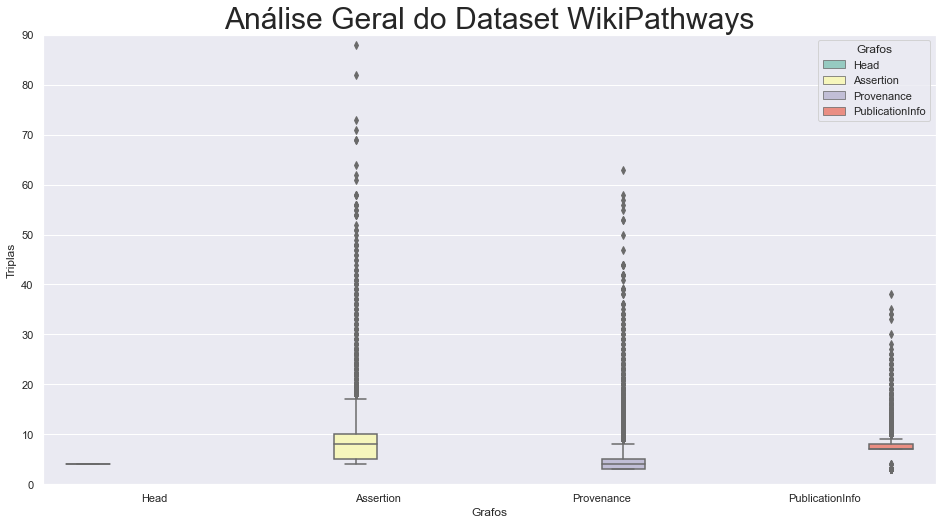

In [37]:
dataWP = pd.read_csv('distributionWikiPathways.csv')

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(16,8.27)})
ax = sns.boxplot(x="Grafos", y="Triplas", hue="Grafos", data=dataWP, palette="Set3")
ax.axes.set_title("Análise Geral do Dataset WikiPathways",fontsize=30)

#the y-axis is cut-off at a count of 90. The WikiPathways nanopublications include up to 1,001 triples in the assertion graph.
ax.set_ylim(0, 90);

In [475]:
# Contagem de nanopublicações usando dcterms:rights no grafo Publication Info
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select (count(*) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np (dcterms:rights) ?rights .
  }
}
"""

results = queryWP(query)
wpNumRights = get_array(results)
print(wpNumRights)

[16247]


In [476]:
# Lista os diferentes objetos do predicado dcterms:rights no Publication Info e conta quantas ocorrências há
# Interessante notar que bate com o número total de nanopublicações existentes no dataset
# Indicando que todas as nanopublicações declararam o mesmo objeto para dcterms:rights
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select ?rights (count(?rights) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np (dcterms:rights) ?rights .
  }
}
GROUP BY ?rights
"""

results = queryWP(query)
wpRightsCont = get_array3(results)
print(wpRightsCont)

[['http://creativecommons.org/publicdomain/zero/1.0/'], [16247]]


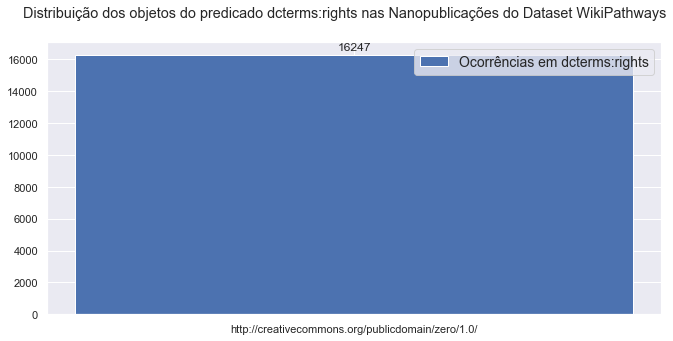

In [40]:
fig, ax = plt.subplots(figsize=(11,5)) # (width, height)
rect = ax.bar(wpRightsCont[0], wpRightsCont[1], label = 'Ocorrências em dcterms:rights')
ax.legend(fontsize = 14)
ax.bar_label(rect, padding=3)
fig.suptitle("Distribuição dos objetos do predicado dcterms:rights nas Nanopublicações do Dataset WikiPathways");
plt.show()

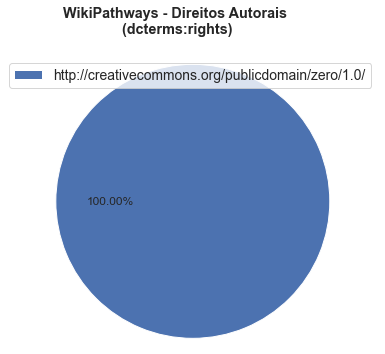

In [424]:
# Exibição do resultado em grafico de pizza
fig, ax = plt.subplots(figsize=(6, 5))
ax.pie(wpRightsCont[1], autopct='%1.2f%%')
ax.axis('equal') # mantenha um circulo
fig.suptitle("WikiPathways - Direitos Autorais\n (dcterms:rights)", fontweight='bold');
plt.legend(wpRightsCont[0], fontsize = 14, loc="best")
plt.tight_layout()
plt.savefig('wikiRights.png')
plt.show()

In [477]:
# Contagem de nanopublicações usando dcterms:rightsHolder no grafo Publication Info
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select (count(*) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np (dcterms:rightsHolder) ?rightsHolder .
  }
}
"""

results = queryWP(query)
wpNumRightsHolder = get_array(results)
print(wpNumRightsHolder)

[0]


In [478]:
# Lista os diferentes objetos do predicado dcterms:rightsHolder no Publication Info e conta quantas ocorrências há
# Nenhum resultado encontrado
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select ?rightsHolder (count(?rightsHolder) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np (dcterms:rightsHolder) ?rightsHolder .
  }
}
GROUP BY ?rightsHolder
"""

results = queryWP(query)
wpRightsHolderCont = get_array5(results)
print(wpRightsHolderCont)

[[], []]


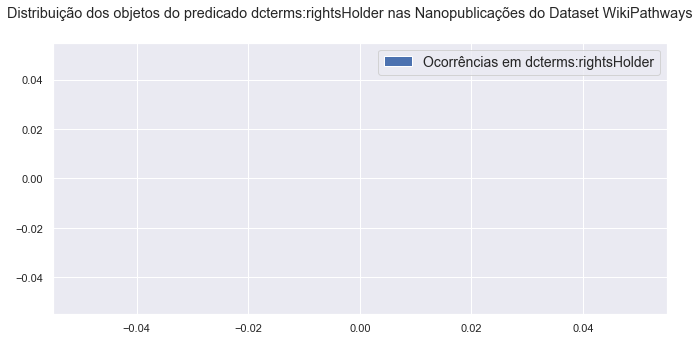

In [44]:
fig, ax = plt.subplots(figsize=(11,5)) # (width, height)
rect = ax.bar(wpRightsHolderCont[0], wpRightsHolderCont[1], label = 'Ocorrências em dcterms:rightsHolder')
ax.legend(fontsize = 14)
ax.bar_label(rect, padding=3)
fig.suptitle("Distribuição dos objetos do predicado dcterms:rightsHolder nas Nanopublicações do Dataset WikiPathways");
plt.show()

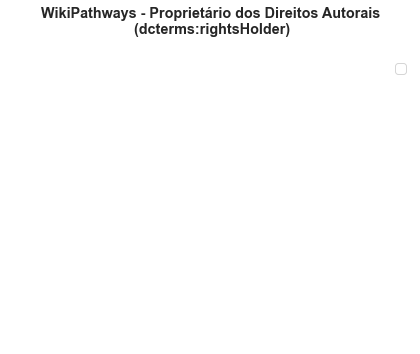

In [426]:
# Exibição do resultado em grafico de pizza
fig, ax = plt.subplots(figsize=(6, 5))
ax.pie(wpRightsHolderCont[1], autopct='%1.2f%%', normalize=True)
ax.axis('equal') # mantenha um circulo
fig.suptitle("WikiPathways - Proprietário dos Direitos Autorais\n (dcterms:rightsHolder)", fontweight='bold');
plt.legend(wpRightsHolderCont[0], fontsize = 14, loc="best")
plt.tight_layout()
plt.savefig('wikiRightsHolder.png')
plt.show()

In [479]:
# Contagem de nanopublicações usando dcterms:licence no grafo Publication Info
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select (count(*) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np (dcterms:licence) ?licence .
  }
}
"""

results = queryWP(query)
wpNumLicence = get_array(results)
print(wpNumLicence)

[0]


In [480]:
# Lista os diferentes objetos do predicado dcterms:licence no Publication Info e conta quantas ocorrências há
# Não foram retornados valores
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select ?licence (count(?licence) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np dcterms:license ?licence .
  }
}
GROUP BY ?licence
"""

results = queryWP(query)
wpLicenceCont = get_array4(results)
print(wpLicenceCont)

[[], []]


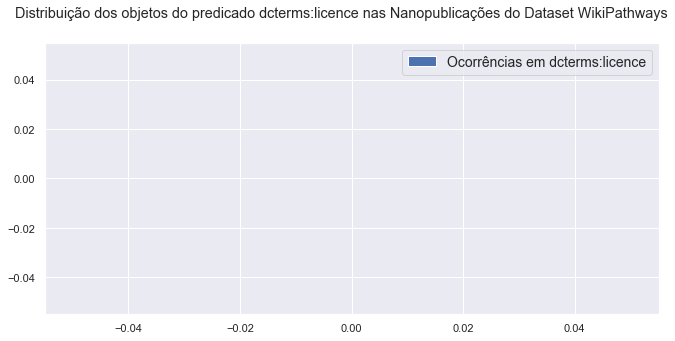

In [48]:
#Zero ocorrência
fig, ax = plt.subplots(figsize=(11,5)) # (width, height)
rect = ax.bar(nxtLicenceCont[0], nxtLicenceCont[1], label = 'Ocorrências em dcterms:licence')
ax.legend(fontsize = 14)
ax.bar_label(rect, padding=3)
fig.suptitle("Distribuição dos objetos do predicado dcterms:licence nas Nanopublicações do Dataset WikiPathways");
plt.show()


fig, ax = plt.subplots(figsize=(11,5)) # (width, height)
rect = ax.bar(wpRightsHolderCont[0], wpRightsHolderCont[1], label = 'Ocorrências em dcterms:licence')
ax.legend(fontsize = 14)
ax.bar_label(rect, padding=3)
fig.suptitle("Distribuição dos objetos do predicado dcterms:licence nas Nanopublicações do Dataset WikiPathways");
plt.show()

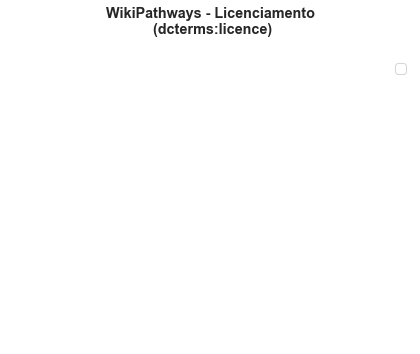

In [433]:
# Exibição do resultado em grafico de pizza
fig, ax = plt.subplots(figsize=(6, 5))
ax.pie(wpLicenceCont[1], autopct='%1.2f%%', normalize=True)
ax.axis('equal') # mantenha um circulo
fig.suptitle("WikiPathways - Licenciamento\n (dcterms:licence)", fontweight='bold');
plt.legend(wpLicenceCont[0], fontsize = 14, loc="best")
plt.tight_layout()
plt.savefig('wikiLicence.png')
plt.show()

## Análise do DisGeNET ##

### [DisGeNet](http://www.disgenet.org/) ###

DisGeNET é uma plataforma de descoberta contendo uma das maiores coleções publicamente disponíveis de genes e variantes associadas a doenças humanas. DisGeNET integra dados de repositórios com curadoria de especialistas, catálogos GWAS, modelos animais e literatura científica. Os dados do DisGeNET são anotados de maneira homogênea com vocabulários controlados e ontologias baseadas na comunidade. Além disso, várias métricas originais são fornecidas para auxiliar na priorização das relações genótipo-fenótipo.

Estamos usando um recorte da versão DisGeNET 4.0.

In [457]:
# A query SPARQL a seguir realiza a contagem de triplas de cada grafo HEAD em cada nanopublicação
query = """
prefix np: <http://www.nanopub.org/nschema#>

select (count(*) as ?count)
where {
  {
    graph ?G {?h a np:Nanopublication .
              }
   } 
  graph ?G {?S ?P ?O}
} 
group by ?G
"""

results = queryDisGeNET(query)
dgHeadTriples = get_array(results)

In [64]:
# A query SPARQL a seguir realiza a contagem de triplas de cada grafo ASSERTION em cada nanopublicação
query = """
    prefix np: <http://www.nanopub.org/nschema#>

        select (count(*) as ?count) where {
          graph ?h {
            ?_np_iri a np:Nanopublication ;
              np:hasAssertion ?a .
          }
          graph ?a {?s ?p ?o}
        } 
        GROUP BY ?a
    """

results = queryDisGeNET(query)
dgAssertionTriples = get_array(results)

In [53]:
# A query SPARQL a seguir realiza a contagem de triplas de cada grafo PROVENANCE em cada nanopublicação
query = """
prefix np: <http://www.nanopub.org/nschema#>

    select (count(*) as ?count) where {
      graph ?h {
        ?_np_iri a np:Nanopublication ;
          np:hasProvenance ?prov .
      }
      graph ?prov {?s ?p ?o}
    } 
    GROUP BY ?prov
"""

results = queryDisGeNET(query)
dgProvenanceTriples = get_array(results)

In [66]:
# A query SPARQL a seguir realiza a contagem de triplas de cada grafo PUBLICATION INFO em cada nanopublicação
query = """
prefix np: <http://www.nanopub.org/nschema#>

    select (count(*) as ?count) where {
      graph ?h {
        ?_np_iri a np:Nanopublication ;
          np:hasPublicationInfo ?pubInfo .
      }
      graph ?pubInfo {?s ?p ?o}
    } 
    GROUP BY ?pubInfo
"""

results = queryDisGeNET(query)
dgPubInfoTriples = get_array(results)

In [61]:
with open('distributionDisGeNET.csv', mode='w') as csv_file:
    fieldnames = ['Grafos', 'Triplas']
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    writer.writerow(['Grafos', 'Triplas'])
    
    # For Head Graph
    for t in dgHeadTriples:
        writer.writerow(['Head', t])
    
    #For Assertion Graph
    for t in dgAssertionTriples:
        writer.writerow(['Assertion', t])
        
    #For Provenance Graph
    for t in dgProvenanceTriples:
        writer.writerow(['Provenance', t])
        
    #For Publication Information Graph
    for t in dgPubInfoTriples:
        writer.writerow(['PublicationInfo', t])

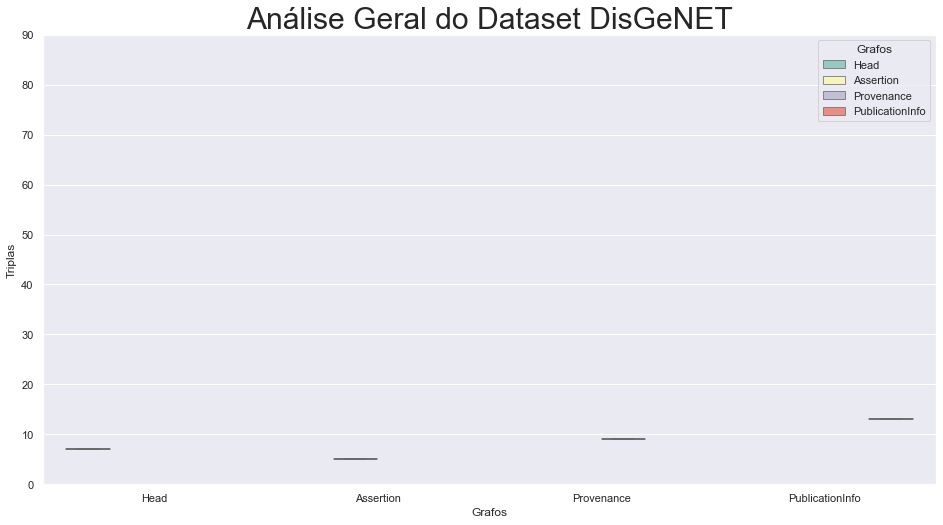

In [62]:
#Run this script if you have not installed virtuoso and jena fuseki
dataDG = pd.read_csv('distributionDisGeNET.csv')

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(16,8.27)})
ax = sns.boxplot(x="Grafos", y="Triplas", hue="Grafos", data=dataDG, palette="Set3")
ax.axes.set_title("Análise Geral do Dataset DisGeNET",fontsize=30)
ax.set_ylim(0, 90);

In [481]:
# Contagem de nanopublicações usando dcterms:rights no grafo Publication Info
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select (count(*) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np (dcterms:rights) ?rights .
  }
}
"""

results = queryDisGeNET(query)
dgNumRights = get_array(results)
print(dgNumRights)

[8235]


In [482]:
# Lista os diferentes objetos do predicado dcterms:rights no Publication Info e conta quantas ocorrências há
# Interessante notar que bate com o número total de nanopublicações existentes no dataset
# Indicando que todas as nanopublicações declararam o mesmo objeto para dcterms:rights
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select ?rights (count(?rights) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np (dcterms:rights) ?rights .
  }
}
GROUP BY ?rights
"""

results = queryDisGeNET(query)
dgRightsCont = get_array3(results)
print(dgRightsCont)

[['http://opendatacommons.org/licenses/odbl/1.0/'], [8235]]


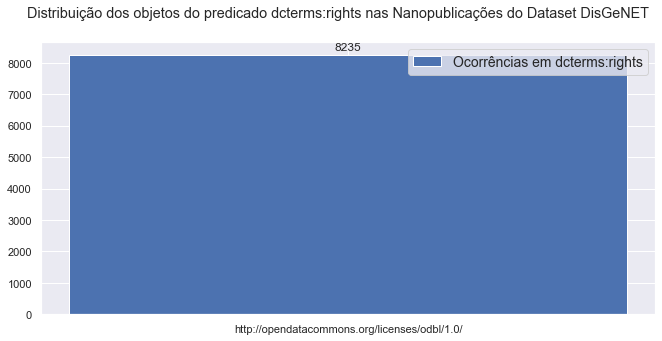

In [70]:
fig, ax = plt.subplots(figsize=(11,5)) # (width, height)
rect = ax.bar(dgRightsCont[0], dgRightsCont[1], label = 'Ocorrências em dcterms:rights')
ax.legend(fontsize = 14)
ax.bar_label(rect, padding=3)
fig.suptitle("Distribuição dos objetos do predicado dcterms:rights nas Nanopublicações do Dataset DisGeNET");
plt.show()

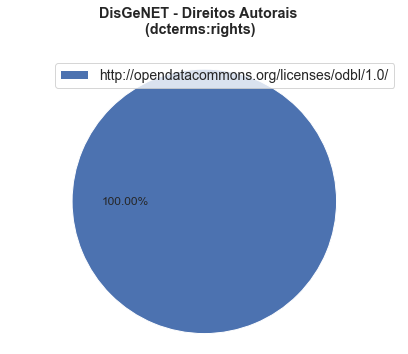

In [434]:
# Exibição do resultado em grafico de pizza
fig, ax = plt.subplots(figsize=(6, 5))
ax.pie(dgRightsCont[1], autopct='%1.2f%%')
ax.axis('equal') # mantenha um circulo
fig.suptitle("DisGeNET - Direitos Autorais\n (dcterms:rights)", fontweight='bold');
plt.legend(dgRightsCont[0], fontsize = 14, loc="best")
plt.tight_layout()
plt.savefig('dgRights.png')
plt.show()

In [483]:
# Contagem de nanopublicações usando dcterms:rightsHolder no grafo Publication Info
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select (count(*) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np (dcterms:rightsHolder) ?rightsHolder .
  }
}
"""

results = queryDisGeNET(query)
dgNumRightsHolder = get_array(results)
print(dgNumRightsHolder)

[8235]


In [484]:
# Lista os diferentes objetos do predicado dcterms:rightsHolder no Publication Info e conta quantas ocorrências há
# Interessante notar que bate com o número total de nanopublicações existentes no dataset
# Indicando que todas as nanopublicações declararam o mesmo objeto para dcterms:rightsHolder
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select ?rightsHolder (count(?rightsHolder) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np (dcterms:rightsHolder) ?rightsHolder .
  }
}
GROUP BY ?rightsHolder
"""

results = queryDisGeNET(query)
dgRightsHolderCont = get_array5(results)
print(dgRightsHolderCont)

[['http://rdf.disgenet.org/v4.0.0/void/IBIGroup'], [8235]]


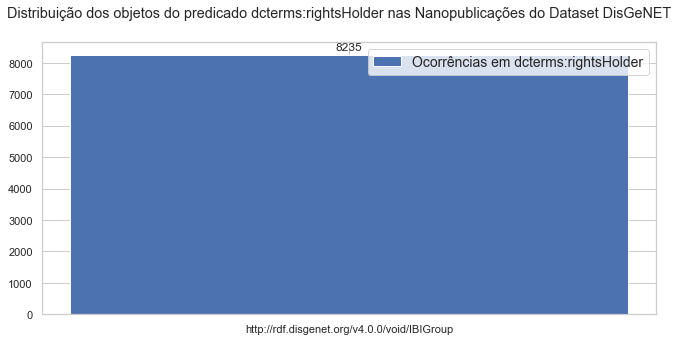

In [463]:
fig, ax = plt.subplots(figsize=(11,5)) # (width, height)
rect = ax.bar(dgRightsHolderCont[0], dgRightsHolderCont[1], label = 'Ocorrências em dcterms:rightsHolder')
ax.legend(fontsize = 14)
ax.bar_label(rect, padding=3)
fig.suptitle("Distribuição dos objetos do predicado dcterms:rightsHolder nas Nanopublicações do Dataset DisGeNET");
plt.show()

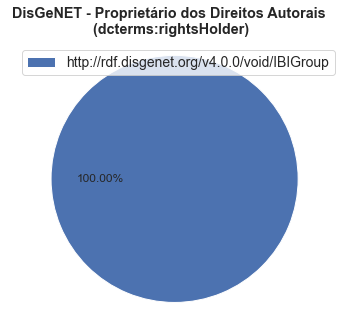

In [464]:
# Exibição do resultado em grafico de pizza
fig, ax = plt.subplots(figsize=(6, 5))
ax.pie(dgRightsHolderCont[1], autopct='%1.2f%%')
ax.axis('equal') # mantenha um circulo
fig.suptitle("DisGeNET - Proprietário dos Direitos Autorais\n (dcterms:rightsHolder)", fontweight='bold');
plt.legend(dgRightsHolderCont[0], fontsize = 14, loc="best")
#plt.tight_layout()
plt.savefig('dgRightsHolder.png')
plt.show()

In [485]:
# Contagem de nanopublicações usando dcterms:licence no grafo Publication Info
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select (count(*) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np dcterms:license ?licence .
  }
}
"""

results = queryDisGeNET(query)
dgNumLicence = get_array(results)
print(dgNumLicence)

[0]


In [486]:
# Lista os diferentes objetos do predicado dcterms:licence no Publication Info e conta quantas ocorrências há
# Nenhum resultado encontrado
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select ?licence (count(?licence) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np dcterms:license ?licence .
  }
}
GROUP BY ?licence
"""

results = queryDisGeNET(query)
dgLicenceCont = get_array4(results)
print(dgLicenceCont)

[[], []]


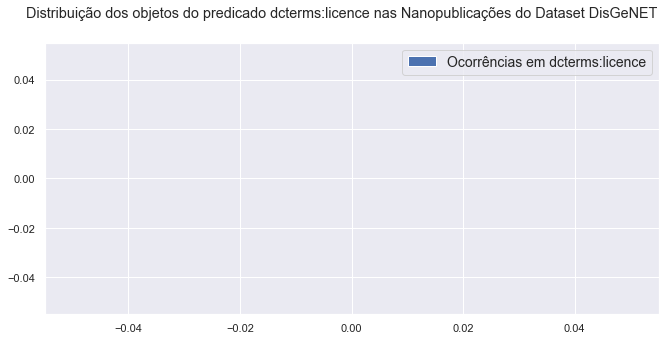

In [79]:
fig, ax = plt.subplots(figsize=(11,5)) # (width, height)
rect = ax.bar(dgLicenceCont[0], dgLicenceCont[1], label = 'Ocorrências em dcterms:licence')
ax.legend(fontsize = 14)
ax.bar_label(rect, padding=3)
fig.suptitle("Distribuição dos objetos do predicado dcterms:licence nas Nanopublicações do Dataset DisGeNET");
plt.show()

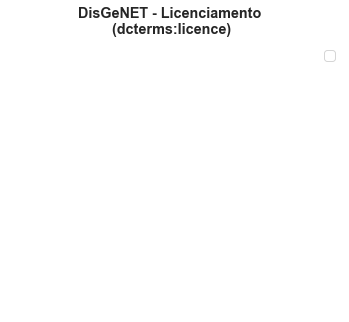

In [438]:
# Exibição do resultado em grafico de pizza
fig, ax = plt.subplots(figsize=(6, 5))
ax.pie(dgLicenceCont[1], autopct='%1.2f%%', normalize=True)
ax.axis('equal') # mantenha um circulo
fig.suptitle("DisGeNET - Licenciamento\n (dcterms:licence)", fontweight='bold');
plt.legend(dgLicenceCont[0], fontsize = 14, loc="best")
#plt.tight_layout()
plt.savefig('dgLicence.png')
plt.show()

## Análise do OpenBel Large Corpus

### [OpenBEL](http://openbel.org/) ###

A linguagem de expressão biológica (BEL) é uma linguagem para representar descobertas científicas nas ciências da vida de uma forma computável. BEL é projetado para representar descobertas científicas capturando relações causais e correlativas no contexto, onde o contexto pode incluir informações sobre o sistema biológico e experimental no qual as relações foram observadas, as publicações de apoio citadas e o processo de curadoria usado.


##### Large Corpus #####
Este corpus não inclui declarações extraídas de tabelas ou experimentos de alto rendimento, e as citações correspondentes não foram necessariamente com curadoria completa como no pequeno corpus. As declarações são uma coleção de observações independentes que não foram selecionadas para representar qualquer processo biológico específico ou via (s) de sinalização. As declarações de controle da transcrição foram selecionadas de maneira equilibrada e as cascatas de sinalização de proteínas foram incluídas em detalhes razoáveis. 

In [90]:
# A query SPARQL a seguir realiza a contagem de triplas de cada grafo HEAD em cada nanopublicação
query = """
   prefix np: <http://www.nanopub.org/nschema#>
select (count(?h) as ?count) where {
      graph ?h {
        ?_np_iri a np:Nanopublication ;
                  ?p ?o .
       }
    }
GROUP BY ?h
    """

results = queryOpenBellLarge(query)
openBellHeadTriples = get_array(results)

In [92]:
# A query SPARQL a seguir realiza a contagem de triplas de cada grafo ASSERTION em cada nanopublicação
query = """
    prefix np: <http://www.nanopub.org/nschema#>

        select (count(*) as ?count) where {
          graph ?h {
            ?_np_iri a np:Nanopublication ;
              np:hasAssertion ?a .
          }
          graph ?a {?s ?p ?o}
        } 
        GROUP BY ?a
    """

results = queryOpenBellLarge(query)
openBellAssertionTriples = get_array(results)

In [94]:
# A query SPARQL a seguir realiza a contagem de triplas de cada grafo PROVENANCE em cada nanopublicação
query = """
prefix np: <http://www.nanopub.org/nschema#>

    select (count(*) as ?count) where {
      graph ?h {
        ?_np_iri a np:Nanopublication ;
          np:hasProvenance ?prov .
      }
      graph ?prov {?s ?p ?o}
    } 
    GROUP BY ?prov
"""

results = queryOpenBellLarge(query)
openBellProvenanceTriples = get_array(results)

In [96]:
# A query SPARQL a seguir realiza a contagem de triplas de cada grafo PUBLICATION INFO em cada nanopublicação
query = """
prefix np: <http://www.nanopub.org/nschema#>

    select (count(*) as ?count) where {
      graph ?h {
        ?_np_iri a np:Nanopublication ;
          np:hasPublicationInfo ?pubInfo .
      }
      graph ?pubInfo {?s ?p ?o}
    } 
    GROUP BY ?pubInfo
"""

results = queryOpenBellLarge(query)
openBellPubInfoTriples = get_array(results)

In [100]:
with open('distributionOpenBel.csv', mode='w') as csv_file:
    fieldnames = ['Grafos', 'Triplas']
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    writer.writerow(['Grafos', 'Triplas'])
    
    # For Head Graph
    for t in openBellHeadTriples:
        writer.writerow(['Head', t])
    
    #For Assertion Graph
    for t in openBellAssertionTriples:
        writer.writerow(['Assertion', t])
        
    #For Provenance Graph
    for t in openBellProvenanceTriples:
        writer.writerow(['Provenance', t])
        
    #For Publication Information Graph
    for t in openBellPubInfoTriples:
        writer.writerow(['PublicationInfo', t])

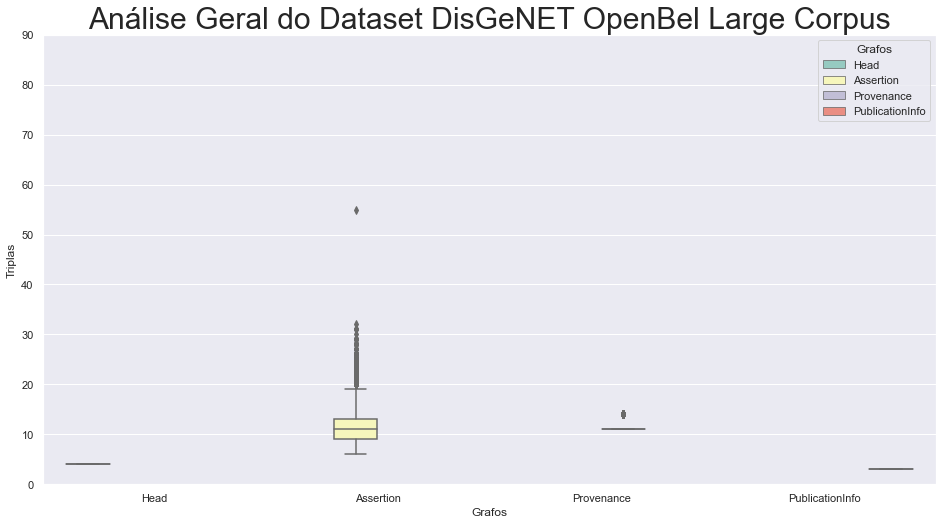

In [101]:
dataOB = pd.read_csv('distributionOpenBel.csv')

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(16,8.27)})
ax = sns.boxplot(x="Grafos", y="Triplas", hue="Grafos", data=dataOB, palette="Set3")
ax.axes.set_title("Análise Geral do Dataset DisGeNET OpenBel Large Corpus",fontsize=30)
ax.set_ylim(0, 90);

In [487]:
# Contagem de nanopublicações usando dcterms:rights no grafo Publication Info
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dce: <http://purl.org/dc/elements/1.1/>
select (count(?rights) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasProvenance ?provenance .
  }
  graph ?provenance {
    ?s dce:rights ?rights .
  }
}
"""

results = queryOpenBellLarge(query)
oblNumRights = get_array(results)
print(oblNumRights)

[48674]


In [488]:
# Lista os diferentes objetos do predicado dce:rights no Provenance e conta quantas ocorrências há
# Interessante notar que bate com o número total de nanopublicações existentes no dataset
# Indicando que todas as nanopublicações declararam o mesmo objeto para dce:rights
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dce: <http://purl.org/dc/elements/1.1/>
select ?rights (count(?rights) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasProvenance ?provenance .
  }
  graph ?provenance {
    ?s dce:rights ?rights .
  }
}
GROUP BY ?rights
"""

results = queryOpenBellLarge(query)
oblRightsCont = get_array3(results)
print(oblRightsCont)

[['Copyright (c) 2011-2012, Selventa. All rights reserved.'], [48674]]


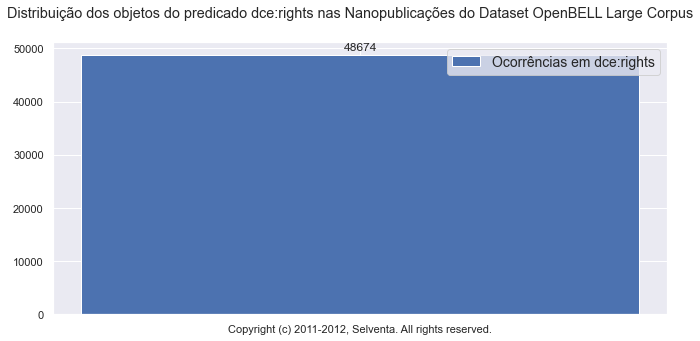

In [109]:
fig, ax = plt.subplots(figsize=(11,5)) # (width, height)
rect = ax.bar(oblRightsCont[0], oblRightsCont[1], label = 'Ocorrências em dce:rights')
ax.legend(fontsize = 14)
ax.bar_label(rect, padding=3)
fig.suptitle("Distribuição dos objetos do predicado dce:rights nas Nanopublicações do Dataset OpenBELL Large Corpus");
plt.show()

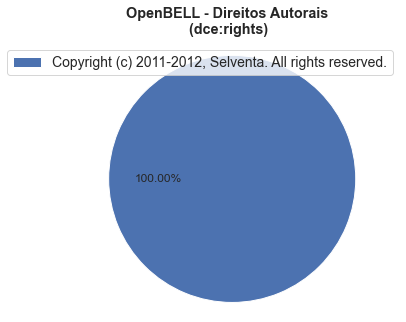

In [447]:
# Exibição do resultado em grafico de pizza
fig, ax = plt.subplots(figsize=(6, 5))
ax.pie(oblRightsCont[1], autopct='%1.2f%%')
ax.axis('equal') # mantenha um circulo
fig.suptitle("OpenBELL - Direitos Autorais\n (dce:rights)", fontweight='bold');
plt.legend(oblRightsCont[0], fontsize = 14, loc="best")
#plt.tight_layout()
plt.savefig('oblRights.png')
plt.show()

In [489]:
# Contagem de nanopublicações usando dcterms:rightsHolder no grafo Publication Info
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select (count(*) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np (dcterms:rightsHolder) ?rightsHolder .
  }
}
"""

results = queryOpenBellLarge(query)
oblNumRightsHolder = get_array(results)
print(oblNumRightsHolder)

[0]


In [490]:
# Lista os diferentes objetos do predicado dcterms:rightsHolder no Publication Info e conta quantas ocorrências há
# Interessante notar que bate com o número total de nanopublicações existentes no dataset
# Indicando que todas as nanopublicações declararam o mesmo objeto para dcterms:rightsHolder
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select ?rightsHolder (count(?rightsHolder) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np (dcterms:rightsHolder) ?rightsHolder .
  }
}
GROUP BY ?rightsHolder
"""

results = queryOpenBellLarge(query)
oblRightsHolderCont = get_array5(results)
print(oblRightsHolderCont)

[[], []]


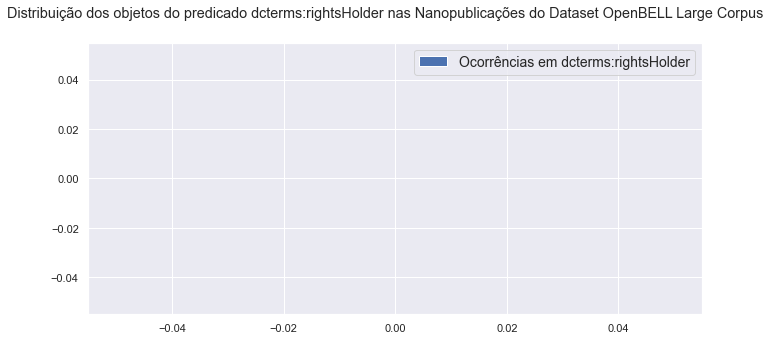

In [118]:
fig, ax = plt.subplots(figsize=(11,5)) # (width, height)
rect = ax.bar(oblRightsHolderCont[0], oblRightsHolderCont[1], label = 'Ocorrências em dcterms:rightsHolder')
ax.legend(fontsize = 14)
ax.bar_label(rect, padding=3)
fig.suptitle("Distribuição dos objetos do predicado dcterms:rightsHolder nas Nanopublicações do Dataset OpenBELL Large Corpus");
plt.show()

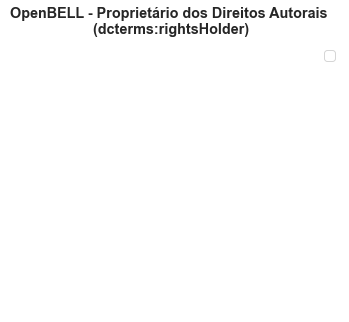

In [442]:
# Exibição do resultado em grafico de pizza
fig, ax = plt.subplots(figsize=(6, 5))
ax.pie(oblRightsHolderCont[1], autopct='%1.2f%%', normalize=True)
ax.axis('equal') # mantenha um circulo
fig.suptitle("OpenBELL - Proprietário dos Direitos Autorais\n (dcterms:rightsHolder)", fontweight='bold');
plt.legend(oblRightsHolderCont[0], fontsize = 14, loc="best")
#plt.tight_layout()
plt.savefig('oblRightsHolder.png')
plt.show()

In [491]:
# Contagem de nanopublicações usando dcterms:licence no grafo Publication Info
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select (count(*) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np dcterms:license ?licence .
  }
}
"""

results = queryOpenBellLarge(query)
oblNumLicence = get_array(results)
print(oblNumLicence)

[0]


In [492]:
# Lista os diferentes objetos do predicado dcterms:licence no Publication Info e conta quantas ocorrências há
# Não foram retornados valores

query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select ?licence (count(?licence) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np dcterms:license ?licence .
  }
}
GROUP BY ?licence
"""

results = queryOpenBellLarge(query)
oblLicenceCont = get_array4(results)
print(oblLicenceCont)

[[], []]


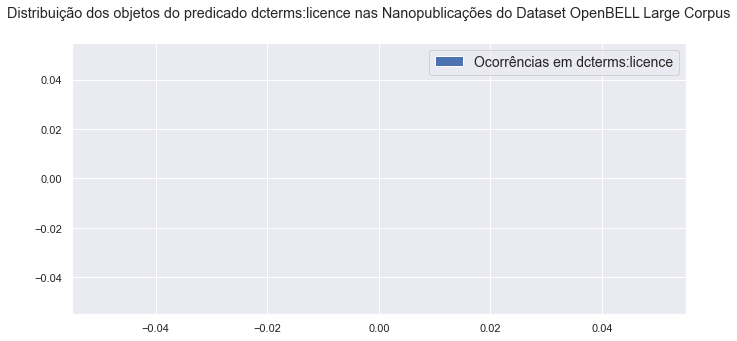

In [122]:
#Zero ocorrência
fig, ax = plt.subplots(figsize=(11,5)) # (width, height)
rect = ax.bar(oblLicenceCont[0], oblLicenceCont[1], label = 'Ocorrências em dcterms:licence')
ax.legend(fontsize = 14)
ax.bar_label(rect, padding=3)
fig.suptitle("Distribuição dos objetos do predicado dcterms:licence nas Nanopublicações do Dataset OpenBELL Large Corpus");
plt.show()

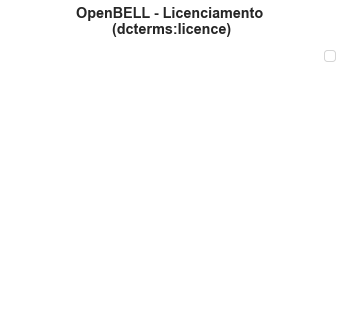

In [456]:
# Exibição do resultado em grafico de pizza
fig, ax = plt.subplots(figsize=(6, 5))
ax.pie(oblLicenceCont[1], autopct='%1.2f%%', normalize=True)
ax.axis('equal') # mantenha um circulo
fig.suptitle("OpenBELL - Licenciamento\n (dcterms:licence)", fontweight='bold');
plt.legend(oblLicenceCont[0], fontsize = 14, loc="best")
#plt.tight_layout()
plt.savefig('oblLicence.png')
plt.show()

## Análise do LInked Drug-Drug Interactions (LIDDI)

### [LIDDI](https://arxiv.org/abs/1507.05408) ###

LInked Drug-Drug Interactions (LIDDI) é um conjunto de dados RDF público baseado em nanopublicação com URIs confiáveis que abrange alguns dos métodos e fontes de previsão mais citados para fornecer aos pesquisadores um recurso para alavancar o trabalho de outros em seus métodos de previsão. Como um dos principais problemas para superar o uso de recursos externos são seus mapeamentos entre nomes de medicamentos e identificadores usados, também fornecemos o conjunto de mapeamentos que organizamos para poder comparar as várias fontes que agregamos em nosso conjunto de dados.

Este conjunto de dados combina dados sobre interações medicamentosas de diferentes fontes e os formata como nanopublicações. 

In [124]:
# A query SPARQL a seguir realiza a contagem de triplas de cada grafo HEAD em cada nanopublicação
query = """
prefix np: <http://www.nanopub.org/nschema#>
select (count(?h) as ?count) where {
      graph ?h {
        ?_np_iri a np:Nanopublication ;
                  ?p ?o .
       }
    }
GROUP BY ?h
"""

results = queryLIDDI(query)
liddiHeadTriples = get_array(results)

In [125]:
# A query SPARQL a seguir realiza a contagem de triplas de cada grafo ASSERTION em cada nanopublicação
query = """
prefix np: <http://www.nanopub.org/nschema#>

    select (count(*) as ?count) where {
      graph ?h {
        ?_np_iri a np:Nanopublication ;
          np:hasAssertion ?a .
      }
      graph ?a {?s ?p ?o}
    } 
    GROUP BY ?a
"""

results = queryLIDDI(query)
liddiAssertionTriples = get_array(results)

In [126]:
# A query SPARQL a seguir realiza a contagem de triplas de cada grafo PROVENANCE em cada nanopublicação
query = """
prefix np: <http://www.nanopub.org/nschema#>

    select (count(*) as ?count) where {
      graph ?h {
        ?_np_iri a np:Nanopublication ;
          np:hasProvenance ?prov .
      }
      graph ?prov {?s ?p ?o}
    } 
    GROUP BY ?prov
"""

results = queryLIDDI(query)
liddiProvenanceTriples = get_array(results)

In [127]:
# A query SPARQL a seguir realiza a contagem de triplas de cada grafo PUBLICATION INFO em cada nanopublicação
query = """
prefix np: <http://www.nanopub.org/nschema#>

    select (count(*) as ?count) where {
      graph ?h {
        ?_np_iri a np:Nanopublication ;
          np:hasPublicationInfo ?pubInfo .
      }
      graph ?pubInfo {?s ?p ?o}
    } 
    GROUP BY ?pubInfo
"""

results = queryLIDDI(query)
liddiPubInfoTriples = get_array(results)

In [129]:
with open('distributionLIDD.csv', mode='w') as csv_file:
    fieldnames = ['Grafo', 'Triplas']
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    writer.writerow(['Grafo', 'Triplas'])
    
    # For Head Graph
    for t in liddiHeadTriples:
        writer.writerow(['Head', t])
    
    #For Assertion Graph
    for t in liddiAssertionTriples:
        writer.writerow(['Assertion', t])
        
    #For Provenance Graph
    for t in liddiProvenanceTriples:
        writer.writerow(['Provenance', t])
        
    #For Publication Information Graph
    for t in liddiPubInfoTriples:
        writer.writerow(['PublicationInfo', t])

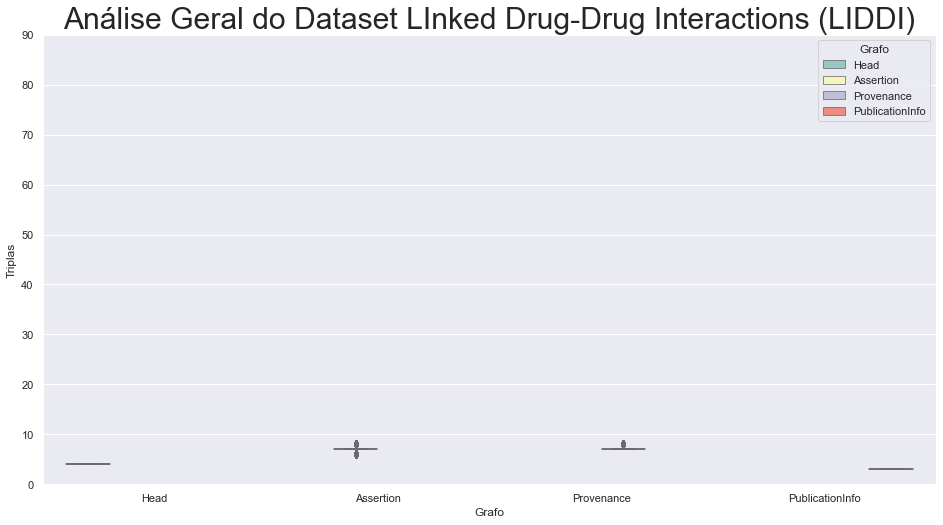

In [130]:
#Run this script if you have not installed virtuoso and jena fuseki
dataLiddi = pd.read_csv('distributionLIDD.csv')

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(16,8.27)})
ax = sns.boxplot(x="Grafo", y="Triplas", hue="Grafo", data=dataLiddi, palette="Set3")
ax.axes.set_title("Análise Geral do Dataset LInked Drug-Drug Interactions (LIDDI)",fontsize=30)
ax.set_ylim(0, 90);

In [493]:
# Contagem de nanopublicações usando dcterms:rights no grafo Publication Info
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select (count(*) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np (dcterms:rights) ?rights .
  }
}
"""

results = queryLIDDI(query)
liddiNumRights = get_array(results)
print(liddiNumRights)

[0]


In [494]:
# Lista os diferentes objetos do predicado dcterms:rights no Publication Info e conta quantas ocorrências há
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select ?rights (count(?rights) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np (dcterms:rights) ?rights .
  }
}
GROUP BY ?rights
"""

results = queryLIDDI(query)
liddiRightsCont = get_array3(results)
print(liddiRightsCont)

[[], []]


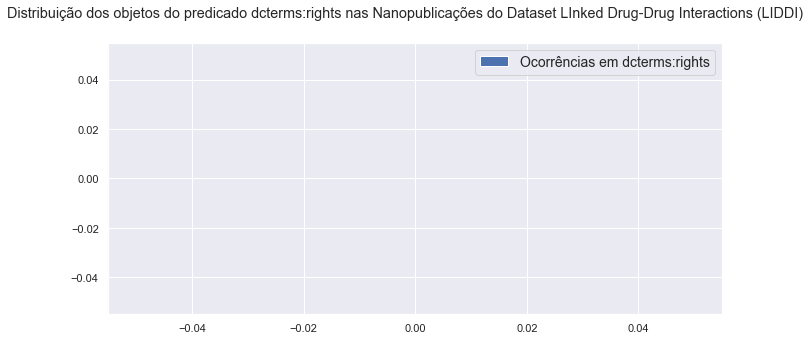

In [135]:
fig, ax = plt.subplots(figsize=(11,5)) # (width, height)
rect = ax.bar(liddiRightsCont[0], liddiRightsCont[1], label = 'Ocorrências em dcterms:rights')
ax.legend(fontsize = 14)
ax.bar_label(rect, padding=3)
fig.suptitle("Distribuição dos objetos do predicado dcterms:rights nas Nanopublicações do Dataset LInked Drug-Drug Interactions (LIDDI)");
plt.show()


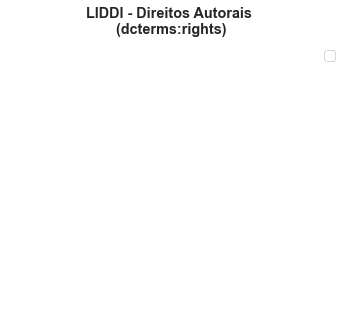

In [444]:
# Exibição do resultado em grafico de pizza
fig, ax = plt.subplots(figsize=(6, 5))
ax.pie(oblLicenceCont[1], autopct='%1.2f%%', normalize=True)
ax.axis('equal') # mantenha um circulo
fig.suptitle("LIDDI - Direitos Autorais\n (dcterms:rights)", fontweight='bold');
plt.legend(oblLicenceCont[0], fontsize = 14, loc="best")
#plt.tight_layout()
plt.savefig('liddiRights.png')
plt.show()

In [495]:
# Contagem de nanopublicações usando dcterms:rightsHolder no grafo Publication Info
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select (count(*) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np (dcterms:rightsHolder) ?rightsHolder .
  }
}
"""

results = queryLIDDI(query)
liddiNumRightsHolder = get_array(results)
print(liddiNumRightsHolder)

[0]


In [496]:
# Lista os diferentes objetos do predicado dcterms:rightsHolder no Publication Info e conta quantas ocorrências há
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select ?rightsHolder (count(?rightsHolder) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np (dcterms:rightsHolder) ?rightsHolder .
  }
}
GROUP BY ?rightsHolder
"""

results = queryLIDDI(query)
liddiRightsHolderCont = get_array5(results)
print(liddiRightsHolderCont)

[[], []]


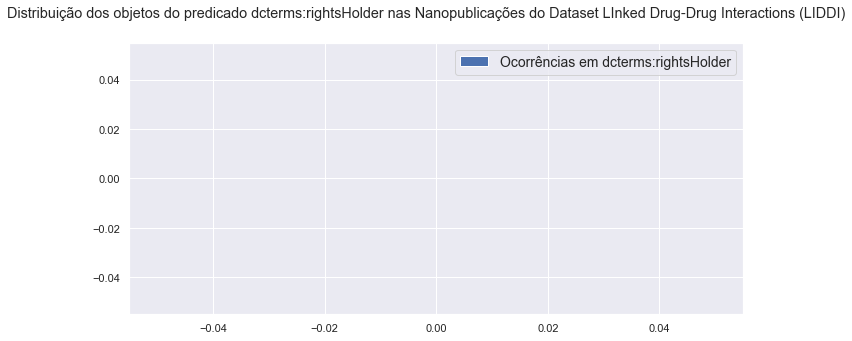

In [142]:
fig, ax = plt.subplots(figsize=(11,5)) # (width, height)
rect = ax.bar(liddiRightsHolderCont[0], liddiRightsHolderCont[1], label = 'Ocorrências em dcterms:rightsHolder')
ax.legend(fontsize = 14)
ax.bar_label(rect, padding=3)
fig.suptitle("Distribuição dos objetos do predicado dcterms:rightsHolder nas Nanopublicações do Dataset LInked Drug-Drug Interactions (LIDDI)");
plt.show()

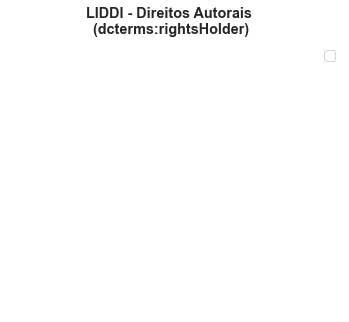

In [445]:
# Exibição do resultado em grafico de pizza
fig, ax = plt.subplots(figsize=(6, 5))
ax.pie(liddiRightsHolderCont[1], autopct='%1.2f%%', normalize=True)
ax.axis('equal') # mantenha um circulo
fig.suptitle("LIDDI - Direitos Autorais\n (dcterms:rightsHolder)", fontweight='bold');
plt.legend(liddiRightsHolderCont[0], fontsize = 14, loc="best")
#plt.tight_layout()
plt.savefig('liddiRightsHolder.png')
plt.show()

In [497]:
# Contagem de nanopublicações usando dcterms:licence no grafo Publication Info
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select (count(*) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np dcterms:license ?licence .
  }
}
"""

results = queryLIDDI(query)
liddiNumLicence = get_array(results)
print(liddiNumLicence)

[88087]


In [498]:
# Lista os diferentes objetos do predicado dcterms:licence no Publication Info e conta quantas ocorrências há
# Interessante notar que bate com o número total de nanopublicações existentes no dataset
# Indicando que todas as nanopublicações declararam o mesmo objeto para dcterms:licence
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select ?licence (count(?licence) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np dcterms:license ?licence .
  }
}
GROUP BY ?licence
"""

results = queryLIDDI(query)
liddiLicenceCont = get_array4(results)
print(liddiLicenceCont)

[['http://creativecommons.org/licenses/by/3.0/'], [88087]]


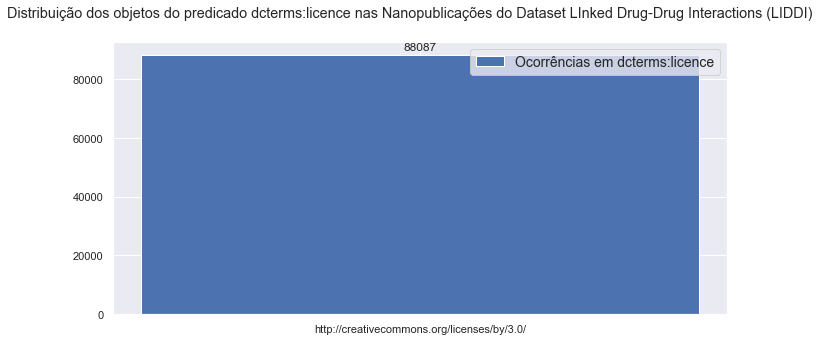

In [147]:
fig, ax = plt.subplots(figsize=(11,5)) # (width, height)
rect = ax.bar(liddiLicenceCont[0], liddiLicenceCont[1], label = 'Ocorrências em dcterms:licence')
ax.legend(fontsize = 14)
ax.bar_label(rect, padding=3)
fig.suptitle("Distribuição dos objetos do predicado dcterms:licence nas Nanopublicações do Dataset LInked Drug-Drug Interactions (LIDDI)");
plt.show()

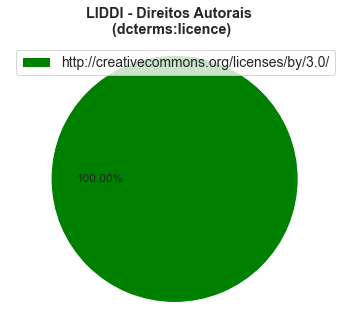

In [455]:
# Exibição do resultado em grafico de pizza
fig, ax = plt.subplots(figsize=(6, 5))
ax.pie(liddiLicenceCont[1], autopct='%1.2f%%', colors=['green'])
ax.axis('equal') # mantenha um circulo
fig.suptitle("LIDDI - Direitos Autorais\n (dcterms:licence)", fontweight='bold');
plt.legend(liddiLicenceCont[0], fontsize = 14, loc="best")
#plt.tight_layout()
plt.savefig('liddiLicence.png')
plt.show()

## Análise Geral dos Datasets ##

In [175]:
with open('distributionAll.csv', mode='w') as csv_file:
    fieldnames = ['DataSets', 'Grafos', 'Triplas']
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    writer.writerow(['DataSets', 'Grafos', 'Triplas'])
    
    # NeXtProt DataSet
    for t in nxtHeadTriples:
        writer.writerow(['neXtProt', 'Head', t])
    for t in nxtAssertionTriples:
        writer.writerow(['neXtProt', 'Assertion', t])
    for t in nxtProvenanceTriples:
        writer.writerow(['neXtProt', 'Provenance', t])
    for t in nxtPubInfoTriples:
        writer.writerow(['neXtProt', 'PublicationInfo', t])
    
    # Wikipathways dataset
    for t in wpHeadTriples:
        writer.writerow(['WikiPathways', 'Head', t])
    for t in wpAssertionTriples:
        writer.writerow(['WikiPathways', 'Assertion', t])
    for t in wpProvenanceTriples:
        writer.writerow(['WikiPathways', 'Provenance', t])
    for t in wpPubInfoTriples:
        writer.writerow(['WikiPathways', 'PublicationInfo', t])
        
    # DisGeNet Dataset
    for t in dgHeadTriples:
        writer.writerow(['DisGeNET', 'Head', t])
    for t in dgAssertionTriples:
        writer.writerow(['DisGeNET', 'Assertion', t])
    for t in dgProvenanceTriples:
        writer.writerow(['DisGeNET', 'Provenance', t])
    for t in dgPubInfoTriples:
        writer.writerow(['DisGeNET', 'PublicationInfo', t])
        
    # OpenBell Dataset
    for t in openBellHeadTriples:
        writer.writerow(['OpenBell', 'Head', t])
    for t in openBellAssertionTriples:
        writer.writerow(['OpenBell', 'Assertion', t])
    for t in openBellProvenanceTriples:
        writer.writerow(['OpenBell', 'Provenance', t])
    for t in openBellPubInfoTriples:
        writer.writerow(['OpenBell', 'PublicationInfo', t])
        
    # LIDDI Dataset
    for t in liddiHeadTriples:
        writer.writerow(['LIDDI', 'Head', t])
    for t in liddiAssertionTriples:
        writer.writerow(['LIDDI', 'Assertion', t])
    for t in liddiProvenanceTriples:
        writer.writerow(['LIDDI V', 'Provenance', t])
    for t in liddiPubInfoTriples:
        writer.writerow(['LIDDI', 'PublicationInfo', t])

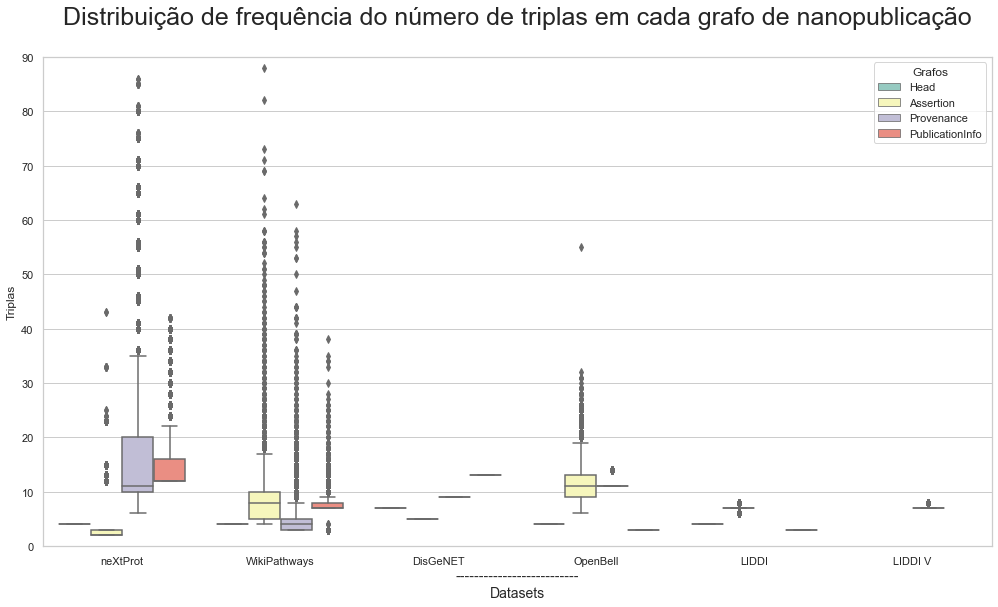

In [177]:
dataAll = pd.read_csv('distributionAll.csv')

sns.set(rc={'figure.figsize':(17,9)})
sns.set(style="whitegrid")

ax = sns.boxplot(x="DataSets", y="Triplas", hue="Grafos", data=dataAll, palette="Set3")
ax.axes.set_title("Distribuição de frequência do número de triplas em cada grafo de nanopublicação\n",fontsize=25)
ax.axes.set_xlabel('--------------------------\nDatasets', fontsize=14)

#the y-axis is cut-off at a count of 90. The WikiPathways nanopublications include up to 1,001 triples in the assertion graph.
ax.set_ylim(0, 90);
plt.show()

## Contagem do Número Médio de Triplas

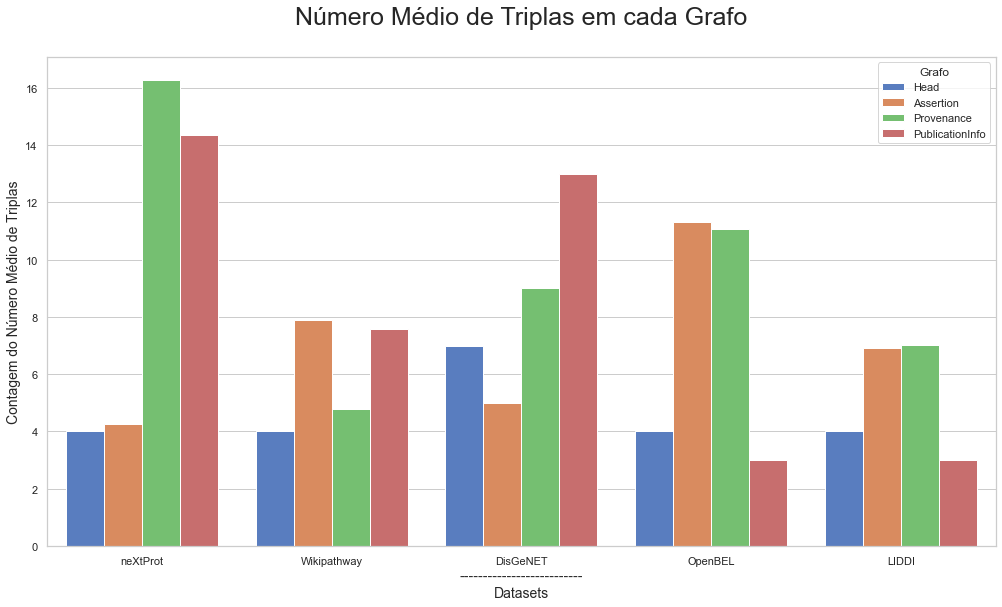

In [183]:
nxtHeadTriplesAvg = average(nxtHeadTriples)
nxtAssertionTriplesAvg = average(nxtAssertionTriples)
nxtProvenanceTriplesAvg = average(nxtProvenanceTriples)
nxtPubInfoTriplesAvg = average(nxtPubInfoTriples)

wpHeadTriplesAvg = average(wpHeadTriples)
wpAssertionTriplesAvg = average(wpAssertionTriples)
wpProvenanceTriplesAvg = average(wpProvenanceTriples)
wpPubInfoTriplesAvg = average(wpPubInfoTriples)

dgHeadTriplesAvg = average(dgHeadTriples)
dgAssertionTriplesAvg = average(dgAssertionTriples)
dgProvenanceTriplesAvg = average(dgProvenanceTriples)
dgPubInfoTriplesAvg = average(dgPubInfoTriples)


openBellHeadTriplesAvg = average(openBellHeadTriples)
openBellAssertionTriplesAvg = average(openBellAssertionTriples)
openBellProvenanceTriplesAvg = average(openBellProvenanceTriples)
openBellPubInfoTriplesAvg = average(openBellPubInfoTriples)


liddiHeadTriplesAvg = average(liddiHeadTriples)
liddiAssertionTriplesAvg = average(liddiAssertionTriples)
liddiProvenanceTriplesAvg = average(liddiProvenanceTriples)
liddiPubInfoTriplesAvg = average(liddiPubInfoTriples)



df = pd.DataFrame(columns=["Dataset","Grafo","Triplas"], 
                  data=[['neXtProt', 'Head', nxtHeadTriplesAvg],
                        ['neXtProt', 'Assertion', nxtAssertionTriplesAvg],
                        ['neXtProt', 'Provenance', nxtProvenanceTriplesAvg],
                        ['neXtProt', 'PublicationInfo', nxtPubInfoTriplesAvg],
                        ['Wikipathway', 'Head', wpHeadTriplesAvg],
                        ['Wikipathway', 'Assertion', wpAssertionTriplesAvg],
                        ['Wikipathway', 'Provenance', wpProvenanceTriplesAvg],
                        ['Wikipathway', 'PublicationInfo', wpPubInfoTriplesAvg],
                        ['DisGeNET', 'Head', dgHeadTriplesAvg],
                        ['DisGeNET', 'Assertion', dgAssertionTriplesAvg],
                        ['DisGeNET', 'Provenance', dgProvenanceTriplesAvg],
                        ['DisGeNET', 'PublicationInfo', dgPubInfoTriplesAvg],
                        ['OpenBEL', 'Head', openBellHeadTriplesAvg],
                        ['OpenBEL', 'Assertion', openBellAssertionTriplesAvg],
                        ['OpenBEL', 'Provenance', openBellProvenanceTriplesAvg],
                        ['OpenBEL', 'PublicationInfo', openBellPubInfoTriplesAvg],
                        ['LIDDI', 'Head', liddiHeadTriplesAvg],
                        ['LIDDI', 'Assertion', liddiAssertionTriplesAvg],
                        ['LIDDI', 'Provenance', liddiProvenanceTriplesAvg],
                        ['LIDDI', 'PublicationInfo', liddiPubInfoTriplesAvg]
                        ])

sns.set(style="whitegrid")

ax = sns.barplot(x="Dataset", y="Triplas", hue="Grafo", data=df, ci='sd', palette="muted")
ax.axes.set_xlabel('--------------------------\nDatasets', fontsize=14)
ax.axes.set_ylabel('Contagem do Número Médio de Triplas', fontsize=14)
ax.axes.set_title("Número Médio de Triplas em cada Grafo\n",fontsize=25)
plt.show()

## Grafo HEAD nos Datasets

In [184]:
with open('distributionHead.csv', mode='w') as csv_file:
    fieldnames = ['DataSets', 'Triplas']
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    writer.writerow(['DataSets', 'Triplas'])
    
    # For NeXtProt DataSet
    for t in nxtHeadTriples:
        writer.writerow(['neXtProt', t])
        
    #For Wikipathways dataset
    for t in wpHeadTriples:
        writer.writerow(['Wikipathway', t])
        
    #For DisGeNet Dataset
    for t in dgHeadTriples:
        writer.writerow(['DisGeNET', t])
        
    #For OpenBell Dataset
    for t in openBellHeadTriples:
        writer.writerow(['OpenBEL', t])
        
    #For LIDDI Dataset
    for t in liddiHeadTriples:
        writer.writerow(['LIDDI', t])

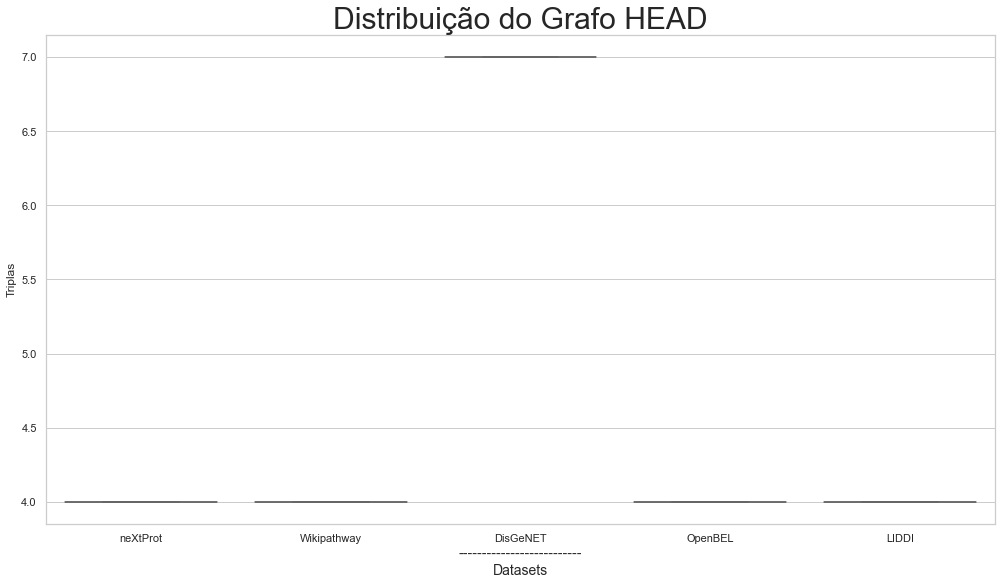

In [187]:
dataAssertions = pd.read_csv('distributionHead.csv')

sns.set(style="whitegrid")
#sns.set(rc={'figure.figsize':(16,8.27)})
ax = sns.boxplot(x="DataSets", y="Triplas", data=dataAssertions, palette="Set3")
ax.axes.set_xlabel('--------------------------\nDatasets', fontsize=14)
ax.axes.set_title("Distribuição do Grafo HEAD",fontsize=30)
#ax.set_ylim(0, 10);
plt.show()

## Grafo ASSERTION nos Datasets ##

In [188]:
with open('distributionAssertion.csv', mode='w') as csv_file:
    fieldnames = ['DataSets', 'Triplas']
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    writer.writerow(['DataSets', 'Triplas'])
    
    # For NeXtProt DataSet
    for t in nxtAssertionTriples:
        writer.writerow(['neXtProt', t])
        
    #For Wikipathways dataset
    for t in wpAssertionTriples:
        writer.writerow(['Wikipathway', t])
        
    #For DisGeNet Dataset
    for t in dgAssertionTriples:
        writer.writerow(['DisGeNET', t])
        
    #For OpenBell Dataset
    for t in openBellAssertionTriples:
        writer.writerow(['OpenBEL', t])
        
    #For LIDDI Dataset
    for t in liddiAssertionTriples:
        writer.writerow(['LIDDI', t])
    

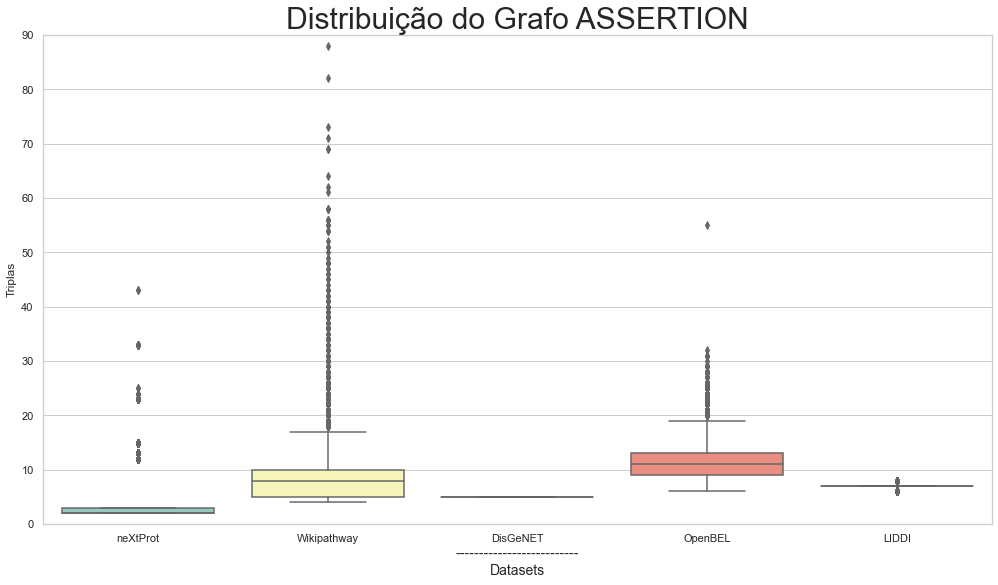

In [193]:
dataAssertions = pd.read_csv('distributionAssertion.csv')

sns.set(style="whitegrid")
#sns.set(rc={'figure.figsize':(16,8.27)})
ax = sns.boxplot(x="DataSets", y="Triplas", data=dataAssertions, palette="Set3")
ax.axes.set_title("Distribuição do Grafo ASSERTION",fontsize=30)
ax.axes.set_xlabel('--------------------------\nDatasets', fontsize=14)
ax.set_ylim(0, 90);
plt.show()

## Grafo PROVENANCE nos Datasets ##

In [191]:
with open('distributionProvenance.csv', mode='w') as csv_file:
    fieldnames = ['DataSets', 'Triplas']
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    writer.writerow(['DataSets', 'Triplas'])
    
    # For NeXtProt DataSet
    for t in nxtProvenanceTriples:
        writer.writerow(['neXtProt', t])
    
    #For Wikipathways dataset
    for t in wpProvenanceTriples:
        writer.writerow(['Wikipathway', t])
        
    #For DisGeNet Dataset
    for t in dgProvenanceTriples:
        writer.writerow(['DisGeNET', t])
        
    #For OpenBell Dataset
    for t in openBellProvenanceTriples:
        writer.writerow(['OpenBEL', t])
        
    #For LIDDI Dataset
    for t in liddiProvenanceTriples:
        writer.writerow(['LIDDI', t])

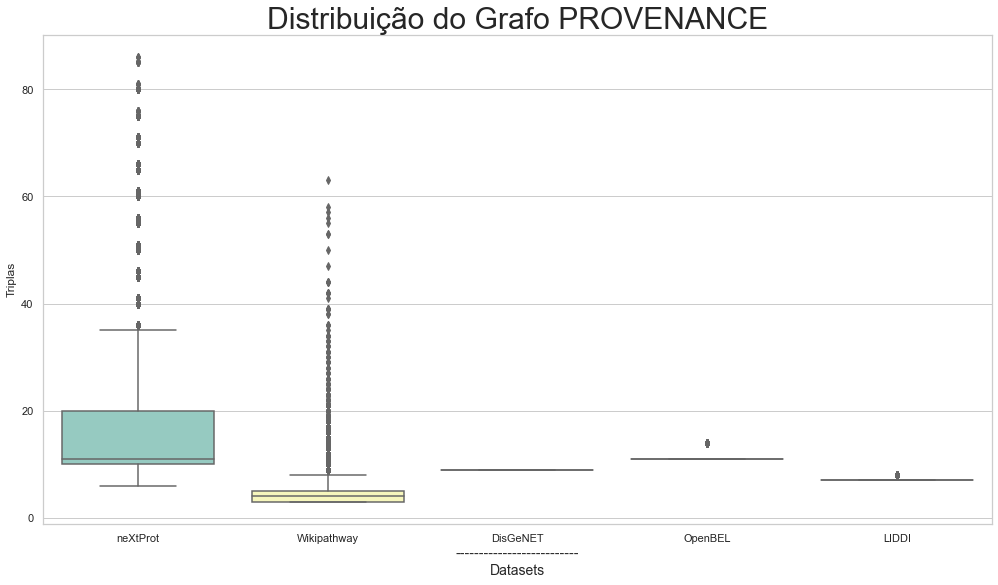

In [194]:
dataProvenance = pd.read_csv('distributionProvenance.csv')

sns.set(style="whitegrid")
#sns.set(rc={'figure.figsize':(16,8.27)})
ax = sns.boxplot(x="DataSets", y="Triplas", data=dataProvenance, palette="Set3")
ax.axes.set_title("Distribuição do Grafo PROVENANCE",fontsize=30)
ax.axes.set_xlabel('--------------------------\nDatasets', fontsize=14)
#ax.set_ylim(0, 90);
plt.show()

## Grafo PUBLICATION INFO nos Datasets ##

In [195]:
with open('distributionPubInfo.csv', mode='w') as csv_file:
    fieldnames = ['DataSets', 'Triplas']
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    writer.writerow(['DataSets', 'Triplas'])
    
    # For NeXtProt DataSet
    for t in nxtPubInfoTriples:
        writer.writerow(['neXtProt', t])
    
    #For Wikipathways dataset
    for t in wpPubInfoTriples:
        writer.writerow(['Wikipathway', t])
        
    #For DisGeNet Dataset
    for t in dgPubInfoTriples:
        writer.writerow(['DisGeNET', t])
        
    #For OpenBell Dataset
    for t in openBellPubInfoTriples:
        writer.writerow(['OpenBEL', t])
        
    #For LIDDI Dataset
    for t in liddiPubInfoTriples:
        writer.writerow(['LIDDI', t])

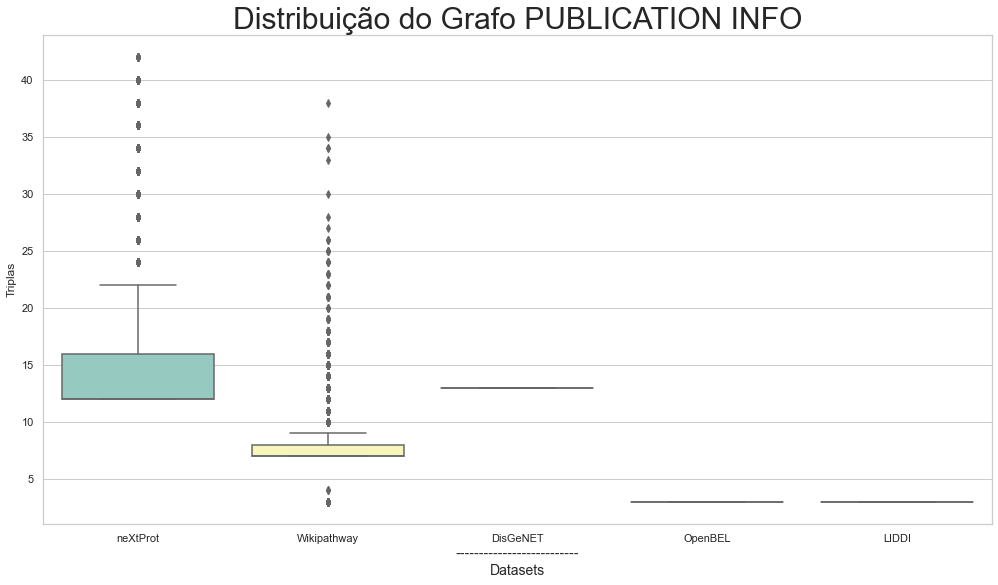

In [196]:
dataPubInfo = pd.read_csv('distributionPubInfo.csv')

sns.set(style="whitegrid")
#sns.set(rc={'figure.figsize':(16,8.27)})
ax = sns.boxplot(x="DataSets", y="Triplas", data=dataPubInfo, palette="Set3")
ax.axes.set_title("Distribuição do Grafo PUBLICATION INFO",fontsize=30)
ax.axes.set_xlabel('--------------------------\nDatasets', fontsize=14)
#ax.set_ylim(0, 90);
plt.show()

## Distribuição de Autores nos Datasets

In [212]:
# Obtendo todos os autores em DisGetNET
query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix npx: <http://purl.org/nanopub/x/>
prefix pav: <http://purl.org/pav/>
prefix prov: <http://www.w3.org/ns/prov#>

select (count(distinct ?author) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (pav:authoredBy) ?author .
  }
}GROUP By ?np"""

results = queryDisGeNET(query)
dgAuthors = get_array(results)
#print(dgAuthors)

In [213]:
# Obtendo todos os autores em neXtProt
query = """
prefix np: <http://www.nanopub.org/nschema#>

select (count(distinct ?author) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np <http://swan.mindinformatics.org/ontologies/1.2/pav/authoredBy> ?author .
  }
}GROUP By ?np"""

results = queryNeXtProt(query)
nxtAuthors = get_array(results)
#print(nxtAuthors)

In [214]:
# Obtendo todos os autores em Wikipathways
query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix npx: <http://purl.org/nanopub/x/>
prefix pav: <http://purl.org/pav/>
prefix prov: <http://www.w3.org/ns/prov#>

select (count(distinct ?author) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (pav:authoredBy) ?author .
  }
}GROUP By ?np"""

results = queryWP(query)
wikiAuthors = get_array(results)
#print(wikiAuthors)
# Obs: Wikipathways não possui autores

In [215]:
# Obtendo todos os autores em OpenBELL Large Corpus
query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix pav: <http://purl.org/pav/>

select (count(distinct ?author) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasProvenance ?prov .
  }
  graph ?prov {
    ?s (pav:authoredBy) ?author .
  }
}GROUP By ?np"""

results = queryOpenBellLarge(query)
openBellAuthors = get_array(results)
#print(openBellAuthors)

In [216]:
# LIDDI não possui autores por ser ter sido gerado por software.

In [222]:
# Todos os dados em arquivo CSV
with open('distributionAuthors.csv', mode='w') as csv_file:
    fieldnames = ['DataSets', 'Count']
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    writer.writerow(['DataSets', 'Count'])
    
    # NeXtProt DataSet
    for t in nxtAuthors:
        writer.writerow(['neXtProt', t])
        
    # Wikipathways dataset
    if (len(wikiAuthors) > 0):
        for t in wikiAuthors:
            writer.writerow(['WikiPathways', t])
    else:
        writer.writerow(['WikiPathways', 0])
        
    # DisGeNet Dataset
    for t in dgAuthors:
        writer.writerow(['DisGeNET', t])
        
    # OpenBell Dataset
    for t in openBellAuthors:
        writer.writerow(['OpenBell', t])
        
    # LIDDI Dataset
    writer.writerow(['LIDDI', 0])

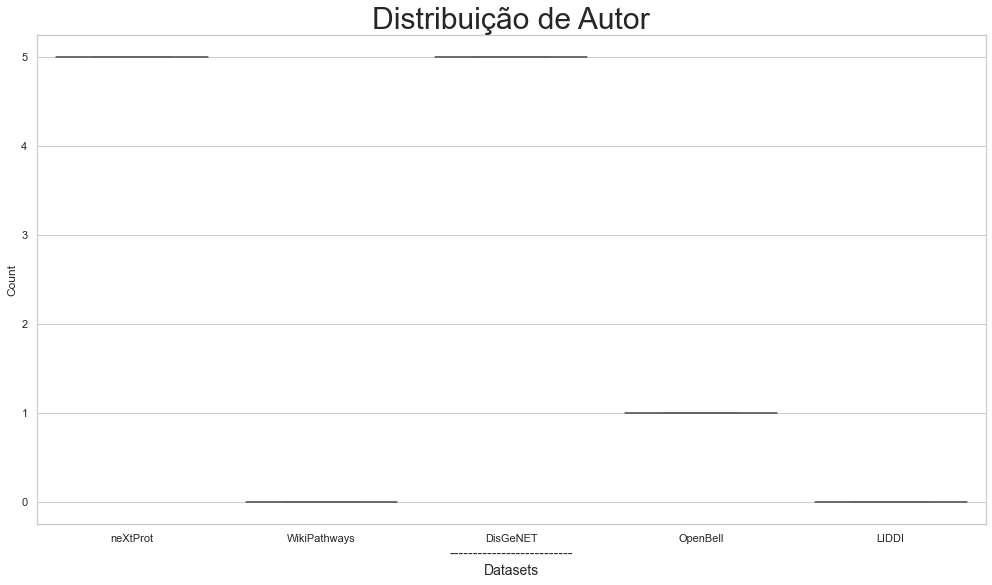

In [223]:
dataAuthors = pd.read_csv('distributionAuthors.csv')

sns.set(style="whitegrid")
ax = sns.boxplot(x="DataSets", y="Count", data=dataAuthors, palette="Set3")
ax.axes.set_title("Distribuição de Autor",fontsize=30)
ax.axes.set_xlabel('--------------------------\nDatasets', fontsize=14)
#ax.set_ylim(0, 10);
plt.show()

## Distribuição de Criador nos Datasets

In [249]:
# Obtendo todos os criadores em DisGetNET
query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>
prefix dce: <http://purl.org/dc/elements/1.1/>
prefix pav: <http://purl.org/pav/>

select (count(distinct ?creator) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (dct:creator|dce:creator|pav:createdBy) ?creator .
  }
}GROUP By ?np"""

results = queryDisGeNET(query)
dgCreators = get_array(results)
#print(dgCreators)

In [226]:
# Obtendo todos os criadores em neXtProt
query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>
prefix dce: <http://purl.org/dc/elements/1.1/>
prefix pav: <http://purl.org/pav/>

select (count(distinct ?creator) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (dct:creator|dce:creator|pav:createdBy) ?creator .
  }
}GROUP By ?np"""

results = queryNeXtProt(query)
nxtCreators = get_array(results)
#print(nxtCreators)

# neXtProt não possui criador

In [227]:
# Obtendo todos os criadores em Wikipathways
query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>
prefix dce: <http://purl.org/dc/elements/1.1/>
prefix pav: <http://purl.org/pav/>

select (count(distinct ?creator) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (dct:creator|dce:creator|pav:createdBy) ?creator .
  }
}GROUP By ?np"""

results = queryWP(query)
wikiCreators = get_array(results)
#print(wikiCreators)

In [228]:
# Obtendo todos os criadores em OpenBELL Large Corpus
query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>
prefix dce: <http://purl.org/dc/elements/1.1/>
prefix pav: <http://purl.org/pav/>

select (count(distinct ?creator) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (dct:creator|dce:creator|pav:createdBy) ?creator .
  }
}GROUP By ?np"""

results = queryOpenBellLarge(query)
openBellCreators = get_array(results)
#print(openBellCreators)

In [229]:
# Obtendo todos os criadores em LIDDI
query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix prov: <http://www.w3.org/ns/prov#>

select (count(distinct ?creator) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (prov:wasAttributedTo) ?creator .
  }
}GROUP By ?np"""

results = queryLIDDI(query)
liddiCreators = get_array(results)
#print(liddiCreators)

In [230]:
# Dados em arquivo CSV
with open('distributionCreators.csv', mode='w') as csv_file:
    fieldnames = ['DataSets', 'Count']
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    writer.writerow(['DataSets', 'Count'])
    
    # For NeXtProt DataSet
    if (len(nxtCreators) > 0):
        for t in nxtCreators:
            writer.writerow(['NeXtProt', t])
    else:
        writer.writerow(['NeXtProt', 0])
        
    #For Wikipathways dataset
    if (len(wikiCreators) > 0):
        for t in wikiCreators:
            writer.writerow(['WikiPathways', t])
    else:
        writer.writerow(['WikiPathways', 0])   
        
    #For DisGeNet Dataset
    for t in dgCreators:
        writer.writerow(['DisGeNET', t])
        
    #For OpenBell Dataset
    for t in openBellCreators:
        writer.writerow(['OpenBell', t])

    #For LIDDI Dataset
    for t in liddiCreators:
        writer.writerow(['LIDDI', t])

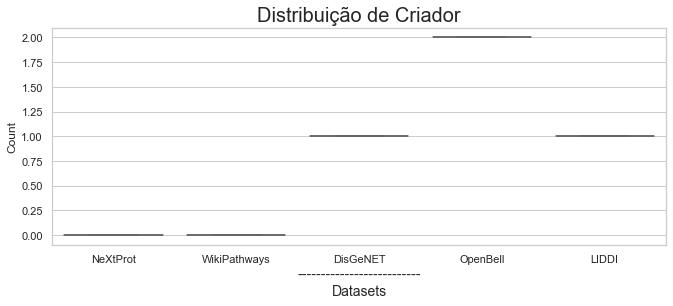

In [247]:
dataCreators = pd.read_csv('distributionCreators.csv')

sns.set(style="whitegrid", rc={'figure.figsize':(11,4)})
ax = sns.boxplot(x="DataSets", y="Count", data=dataCreators, palette="Set3")
ax.axes.set_title("Distribuição de Criador",fontsize=20)
ax.axes.set_xlabel('--------------------------\nDatasets', fontsize=14)
#ax.set_ylim(0, 10);
plt.show()

## Distribuição de Rights (Direitos Autorais), RightsHolder (Proprietário dos Direitos) e Licence (Licenciamento) nos Datasets

In [499]:
# Obtendo todos os rights em DisGetNET
query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>

select (count(distinct ?rights) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (dct:rights) ?rights .
  }
}GROUP By ?np"""

results = queryDisGeNET(query)
dgRights = get_array(results)
#print(dgRights)

# Obtendo todos os rightsHolder em DisGetNET
query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>

select (count(distinct ?rightsHolder) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (dct:rightsHolder) ?rightsHolder .
  }
}GROUP By ?np"""

results = queryDisGeNET(query)
dgRightsHolder = get_array(results)
#print(dgRightsHolder)

# Obtendo todos os licence em DisGetNET
query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>

select (count(distinct ?licence) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (dct:licence) ?licence .
  }
}GROUP By ?np"""

results = queryDisGeNET(query)
dgLicence = get_array(results)
#print(dgLicence)

query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>

select ?rights (count(distinct ?rights) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (dct:rights) ?rights .
  }
}GROUP By ?rights"""

results = queryDisGeNET(query)
dgRightsCont = get_array3(results)
#print(dgRightsCont)

query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>

select ?rightsHolder (count(distinct ?rightsHolder) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (dct:rightsHolder) ?rightsHolder .
  }
}GROUP By ?rightsHolder"""

results = queryDisGeNET(query)
dgRightsHolderCont = get_array5(results)
#print(dgRightsHolderCont)

query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>

select ?licence (count(distinct ?licence) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (dct:licence) ?licence .
  }
}GROUP By ?licence"""

results = queryDisGeNET(query)
dgLicenceCont = get_array4(results)
#print(dgLicenceCont)

In [500]:
# Obtendo todos os rights em neXtProt
query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>

select (count(distinct ?rights) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (dct:rights) ?rights .
  }
}GROUP By ?np"""

results = queryNeXtProt(query)
nxtRights = get_array(results)
#print(nxtRights)

# Obtendo todos os rightsHolder em neXtProt
query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dcterms: <http://purl.org/dc/terms/>

select (count(distinct ?rightsHolder) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (dcterms:rightsHolder) ?rightsHolder.
  }
}GROUP By ?np"""

results = queryNeXtProt(query)
nxtRightsHolder = get_array(results)
#print(nxtRightsHolder)

# Obtendo todos os licence em neXtProt
query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>

select (count(distinct ?licence) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (dct:licence) ?licence .
  }
}GROUP By ?np"""

results = queryNeXtProt(query)
nxtLicence = get_array(results)
#print(nxtLicence)

query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>

select ?rights (count(distinct ?rights) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (dct:rights) ?rights .
  }
}GROUP By ?rights"""

results = queryNeXtProt(query)
nxtRightsCont = get_array3(results)
#print(nxtRightsCont)

query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>

select ?rightsHolder (count(distinct ?rightsHolder) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (dct:rightsHolder) ?rightsHolder .
  }
}GROUP By ?rightsHolder"""

results = queryNeXtProt(query)
nxtRightsHolderCont = get_array5(results)
#print(nxtRightsHolderCont)

query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>

select ?licence (count(distinct ?licence) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (dct:licence) ?licence .
  }
}GROUP By ?licence"""

results = queryNeXtProt(query)
nxtLicenceCont = get_array4(results)
#print(nxtLicenceCont)

In [501]:
# Obtendo todos os rights em Wikipathways
query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>

select (count(distinct ?rights) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (dct:rights) ?rights .
  }
}GROUP By ?np"""

results = queryWP(query)
wikiRights = get_array(results)
#print(wikiRights)

# Obtendo todos os rightsHolder em Wikipathways
query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>

select (count(distinct ?rightsHolder) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (dct:rightsHolder) ?rightsHolder .
  }
}GROUP By ?np"""

results = queryWP(query)
wikiRightsHolder = get_array(results)
#print(wikiRightsHolder)

# Obtendo todos os Licence em Wikipathways
query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>

select (count(distinct ?licence) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (dct:licence) ?licence .
  }
}GROUP By ?np"""

results = queryWP(query)
wikiLicence = get_array(results)
print(wikiLicence)

query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>

select ?rights (count(distinct ?rights) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (dct:rights) ?rights .
  }
}GROUP By ?rights"""

results = queryWP(query)
wikiRightsCont = get_array3(results)
#print(wikiRightsCont)

query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>

select ?rightsHolder (count(distinct ?rightsHolder) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (dct:rightsHolder) ?rightsHolder .
  }
}GROUP By ?rightsHolder"""

results = queryWP(query)
wikiRightsHolderCont = get_array5(results)
#print(wikiRightsHolderCont)

query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>

select ?licence (count(distinct ?licence) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (dct:licence) ?licence .
  }
}GROUP By ?licence"""

results = queryWP(query)
wikiLicenceCont = get_array4(results)
print(wikiLicenceCont)

[]
[[], []]


In [502]:
# Obtendo todos os rights em OpenBELL Large Corpus
query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>
prefix dce: <http://purl.org/dc/elements/1.1/>

select (count(distinct ?rights) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasProvenance ?provenance .
  }
  graph ?provenance {
    <http://resource.belframework.org/belframework/1.0/knowledge/large_corpus.bel> (dct:rights|dce:rights) ?rights .
  }
}GROUP By ?np"""

results = queryOpenBellLarge(query)
openBellRights = get_array(results)
#print(openBellRights)

# Obtendo todos os rightsHolder em OpenBELL Large Corpus
query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>

select (count(distinct ?rightsHolder) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (dct:rightsHolder) ?rightsHolder .
  }
}GROUP By ?np"""

results = queryOpenBellLarge(query)
openBellRightsHolder = get_array(results)
#print(openBellRightsHolder)

# Obtendo todos os Licence em OpenBELL Large Corpus
query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>

select (count(distinct ?licence) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (dct:licence) ?licence .
  }
}GROUP By ?np"""

results = queryOpenBellLarge(query)
openBellLicence = get_array(results)
#print(openBellLicence)

query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>
prefix dce: <http://purl.org/dc/elements/1.1/>

select ?rights (count(distinct ?rights) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasProvenance ?provenance .
  }
  graph ?provenance {
    <http://resource.belframework.org/belframework/1.0/knowledge/large_corpus.bel> (dct:rights|dce:rights) ?rights .
  }
}GROUP By ?rights"""

results = queryOpenBellLarge(query)
openBellRightsCont = get_array3(results)
#print(openBellRightsCont)

query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>

select ?rightsHolder (count(distinct ?rightsHolder) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (dct:rightsHolder) ?rightsHolder .
  }
}GROUP By ?rightsHolder"""

results = queryOpenBellLarge(query)
openBellRightsHolderCont = get_array5(results)
#print(openBellRightsHolderCont)

query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>

select ?licence (count(distinct ?licence) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (dct:licence) ?licence .
  }
}GROUP By ?licence"""

results = queryOpenBellLarge(query)
openBellLicenceCont = get_array4(results)
#print(openBellLicenceCont)

In [503]:
# Obtendo todos os rights em LIDDI
query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dcterms: <http://purl.org/dc/terms/>

select (count(distinct ?rights) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (dcterms:rights) ?rights .
  }
}GROUP By ?np"""

results = queryLIDDI(query)
liddiRights = get_array(results)
#print(liddiRights)

# Obtendo todos os rightsHolder em LIDDI
query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dcterms: <http://purl.org/dc/terms/>

select (count(distinct ?rightsHolder) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (dcterms:rightsHolder) ?rightsHolder .
  }
}GROUP By ?np"""

results = queryLIDDI(query)
liddiRightsHolder = get_array(results)
#print(liddiRightsHolder)

# Obtendo todos os licence em LIDDI
query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dcterms: <http://purl.org/dc/terms/>

select (count(distinct ?licence) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (dcterms:license) ?licence .
  }
}GROUP By ?np"""

results = queryLIDDI(query)
liddiLicence = get_array(results)
#print(liddiLicence)

query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>
prefix dce: <http://purl.org/dc/elements/1.1/>

select ?rights (count(distinct ?rights) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasProvenance ?provenance .
  }
  graph ?provenance {
    <http://resource.belframework.org/belframework/1.0/knowledge/large_corpus.bel> (dct:rights|dce:rights) ?rights .
  }
}GROUP By ?rights"""

results = queryLIDDI(query)
liddiRightsCont = get_array3(results)
#print(liddiRightsCont)

query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>

select ?rightsHolder (count(distinct ?rightsHolder) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (dct:rightsHolder) ?rightsHolder .
  }
}GROUP By ?rightsHolder"""

results = queryLIDDI(query)
liddiRightsHolderCont = get_array5(results)
#print(liddiRightsHolderCont)

query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select ?licence (count(distinct ?licence) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np dcterms:license ?licence .
  }
}
GROUP BY ?licence"""

results = queryLIDDI(query)
liddiLicenceCont = get_array4(results)
#print(liddiLicenceCont)

In [504]:
with open('distributionRights.csv', mode='w') as csv_file:
    fieldnames = ['DataSets', 'Count']
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    writer.writerow(['DataSets', 'Count'])
    
    # NeXtProt DataSet
    if (len(nxtRights) > 0):
        for t in nxtRights:
            writer.writerow(['NeXtProt', t])
    else:
        writer.writerow(['NeXtProt', 0])
        
    # Wikipathways dataset
    if (len(wikiRights) > 0):
        for t in wikiRights:
            writer.writerow(['WikiPathways', t])
    else:
        writer.writerow(['WikiPathways', 0])   
        
    #For DisGeNet Dataset
    for t in dgRights:
        writer.writerow(['DisGeNET', t])
        
    # OpenBell Dataset
    for t in openBellRights:
        writer.writerow(['OpenBell', t])

    # LIDDI Dataset
    #for t in liddiRights:
    #    writer.writerow(['LIDDI', t])        
    if (len(liddiRights) > 0):
        for t in liddiRights:
            writer.writerow(['LIDDI', t])
    else:
        writer.writerow(['LIDDI', 0])  

## Distribuição de Rights em cada Dataset

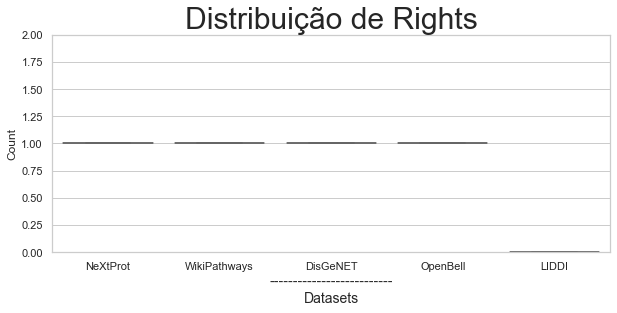

In [390]:
dataRights = pd.read_csv('distributionRights.csv')

sns.set(style="whitegrid")
ax = sns.boxplot(x="DataSets", y="Count", data=dataRights, palette="Set3")
ax.axes.set_title("Distribuição de Rights",fontsize=30)
ax.axes.set_xlabel('--------------------------\nDatasets', fontsize=14)
ax.set_ylim(0, 2);
plt.savefig('RigthsxDatasets.png')

In [505]:
with open('distributionRightsHolder.csv', mode='w') as csv_file:
    fieldnames = ['DataSets', 'Count']
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    writer.writerow(['DataSets', 'Count'])
    
    # NeXtProt DataSet
    if (len(nxtRightsHolder) > 0):
        for t in nxtRightsHolder:
            writer.writerow(['NeXtProt', t])
    else:
        writer.writerow(['NeXtProt', 0])
        
    # Wikipathways dataset
    if (len(wikiRightsHolder) > 0):
        for t in wikiRightsHolder:
            writer.writerow(['WikiPathways', t])
    else:
        writer.writerow(['WikiPathways', 0])   
        
    #For DisGeNet Dataset
    for t in dgRightsHolder:
        writer.writerow(['DisGeNET', t])
        
    # OpenBell Dataset
    if (len(openBellRightsHolder) > 0):
        for t in openBellRightsHolder:
            writer.writerow(['OpenBell', t])
    else:
        writer.writerow(['OpenBell', 0])  

    # LIDDI Dataset
    if (len(liddiRightsHolder) > 0):
        for t in liddiRightsHolder:
            writer.writerow(['LIDDI', t])
    else:
        writer.writerow(['LIDDI', 0])  

## Distribuição de RightsHolder em cada Dataset

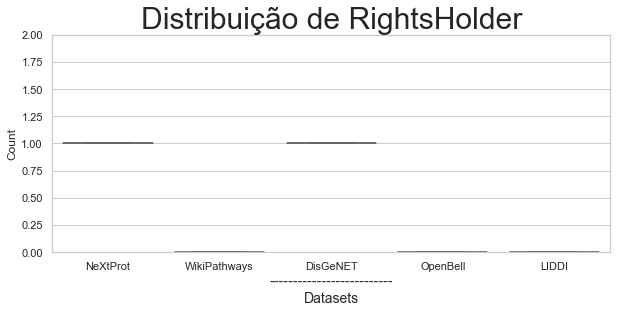

In [453]:
dataRightsHolder = pd.read_csv('distributionRightsHolder.csv')

sns.set(style="whitegrid", rc={'figure.figsize':(10,4)})
ax = sns.boxplot(x="DataSets", y="Count", data=dataRightsHolder, palette="Set3")
ax.axes.set_title("Distribuição de RightsHolder",fontsize=30)
ax.axes.set_xlabel('--------------------------\nDatasets', fontsize=14)
ax.set_ylim(0, 2);
plt.savefig('RigthsHolderxDatasets.png')

In [506]:
with open('distributionLicence.csv', mode='w') as csv_file:
    fieldnames = ['DataSets', 'Count']
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    writer.writerow(['DataSets', 'Count'])
    
    # NeXtProt DataSet
    if (len(nxtLicence) > 0):
        for t in nxtLicence:
            writer.writerow(['NeXtProt', t])
    else:
        writer.writerow(['NeXtProt', 0])
        
    # Wikipathways dataset
    if (len(wikiLicence) > 0):
        for t in wikiLicence:
            writer.writerow(['WikiPathways', t])
    else:
        writer.writerow(['WikiPathways', 0])   
        
    #For DisGeNet Dataset
    for t in dgLicence:
        writer.writerow(['DisGeNET', t])
        
    # OpenBell Dataset
    if (len(openBellLicence) > 0):
        for t in openBellLicence:
            writer.writerow(['OpenBell', t])
    else:
        writer.writerow(['OpenBell', 0])  

    # LIDDI Dataset
    if (len(liddiLicence) > 0):
        for t in liddiLicence:
            writer.writerow(['LIDDI', t])
    else:
        writer.writerow(['LIDDI', 0])  

## Distribuição de Licence em cada Dataset

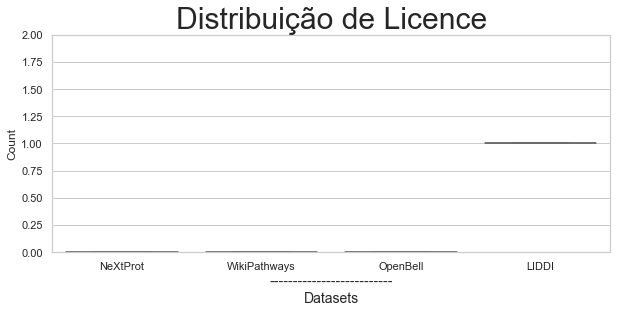

In [393]:
dataRightsHolder = pd.read_csv('distributionLicence.csv')

sns.set(style="whitegrid", rc={'figure.figsize':(10,4)})
ax = sns.boxplot(x="DataSets", y="Count", data=dataRightsHolder, palette="Set3")
ax.axes.set_title("Distribuição de Licence",fontsize=30)
ax.axes.set_xlabel('--------------------------\nDatasets', fontsize=14)
ax.set_ylim(0, 2);
plt.savefig('LicencexDatasets.png')

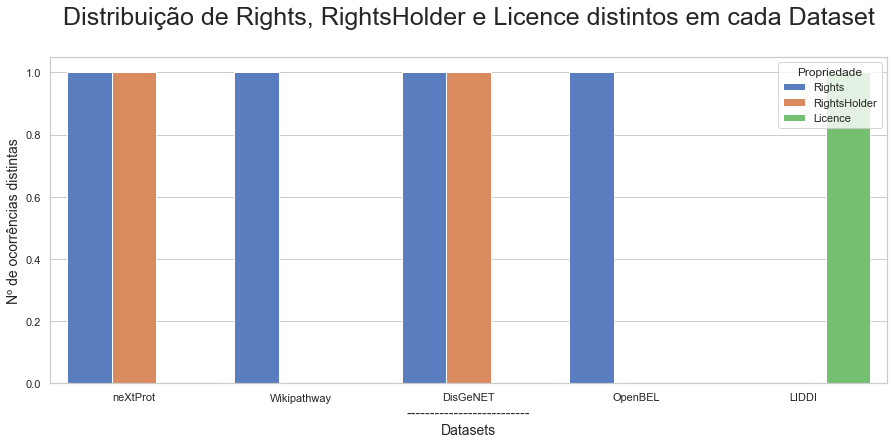

In [508]:
s = [str(i) for i in nxtRightsCont[1]] # Converting integers into strings
nxtRightsContNum = str("".join(s)) # Join the string values into one string
nxtRightsContNum= nxtRightsContNum.strip() or '0'
s = [str(i) for i in wikiRightsCont[1]] # Converting integers into strings
wikiRightsContNum = str("".join(s)) # Join the string values into one string
wikiRightsContNum= wikiRightsContNum.strip() or '0'
s = [str(i) for i in dgRightsCont[1]] # Converting integers into strings
dgRightsContNum = str("".join(s)) # Join the string values into one string
dgRightsContNum= dgRightsContNum.strip() or '0'
s = [str(i) for i in openBellRightsCont[1]] # Converting integers into strings
openBellRightsContNum = str("".join(s)) # Join the string values into one string
openBellRightsContNum= openBellRightsContNum.strip() or '0'
s = [str(i) for i in liddiRightsCont[1]] # Converting integers into strings
liddiRightsContNum = str("".join(s)) # Join the string values into one string
liddiRightsContNum= liddiRightsContNum.strip() or '0'

s = [str(i) for i in nxtRightsHolderCont[1]] # Converting integers into strings
nxtRightsHolderContNum = str("".join(s)) # Join the string values into one string
nxtRightsHolderContNum= nxtRightsHolderContNum.strip() or '0'
s = [str(i) for i in wikiRightsHolderCont[1]] # Converting integers into strings
wikiRightsHolderContNum = str("".join(s)) # Join the string values into one string
wikiRightsHolderContNum= wikiRightsHolderContNum.strip() or '0'
s = [str(i) for i in dgRightsHolderCont[1]] # Converting integers into strings
dgRightsHolderContNum = str("".join(s)) # Join the string values into one string
dgRightsHolderContNum= dgRightsHolderContNum.strip() or '0'
s = [str(i) for i in openBellRightsHolderCont[1]] # Converting integers into strings
openBellRightsHolderContNum = str("".join(s)) # Join the string values into one string
openBellRightsHolderContNum= openBellRightsHolderContNum.strip() or '0'
s = [str(i) for i in liddiRightsCont[1]] # Converting integers into strings
liddiRightsHolderContNum = str("".join(s)) # Join the string values into one string
liddiRightsHolderContNum= liddiRightsHolderContNum.strip() or '0'

s = [str(i) for i in nxtLicenceCont[1]] # Converting integers into strings
nxtLicenceContNum = str("".join(s)) # Join the string values into one string
nxtLicenceContNum= nxtLicenceContNum.strip() or '0'
s = [str(i) for i in wikiLicenceCont[1]] # Converting integers into strings
wikiLicenceContNum = str("".join(s)) # Join the string values into one string
wikiLicenceContNum= wikiLicenceContNum.strip() or '0'
s = [str(i) for i in dgLicenceCont[1]] # Converting integers into strings
dgLicenceContNum = str("".join(s)) # Join the string values into one string
dgLicenceContNum= dgLicenceContNum.strip() or '0'
s = [str(i) for i in openBellLicenceCont[1]] # Converting integers into strings
openBellLicenceContNum = str("".join(s)) # Join the string values into one string
openBellLicenceContNum= openBellLicenceContNum.strip() or '0'
s = [str(i) for i in liddiLicenceCont[1]] # Converting integers into strings
liddiLicenceContNum = str("".join(s)) # Join the string values into one string
liddiLicenceContNum= liddiLicenceContNum.strip() or '0'

df = pd.DataFrame(columns=["Dataset","Propriedade","Triplas"], 
                  data=[['neXtProt', 'Rights', int(nxtRightsContNum)],
                        ['neXtProt', 'RightsHolder', int(nxtRightsHolderContNum)],
                        ['neXtProt', 'Licence', int(nxtLicenceContNum)],
                        ['Wikipathway', 'Rights', int(wikiRightsContNum)],
                        ['Wikipathway', 'RightsHolder', int(wikiRightsHolderContNum)],
                        ['Wikipathway', 'Licence', int(wikiLicenceContNum)],
                        ['DisGeNET', 'Rights', int(dgRightsContNum)],
                        ['DisGeNET', 'RightsHolder', int(dgRightsHolderContNum)],
                        ['DisGeNET', 'Licence', int(dgLicenceContNum)],
                        ['OpenBEL', 'Rights', int(openBellRightsContNum)],
                        ['OpenBEL', 'RightsHolder', int(openBellRightsHolderContNum)],
                        ['OpenBEL', 'Licence', int(openBellLicenceContNum)],
                        ['LIDDI', 'Rights', int(liddiRightsContNum)],
                        ['LIDDI', 'RightsHolder', int(liddiRightsHolderContNum)],
                        ['LIDDI', 'Licence', int(liddiLicenceContNum)],
                        ])

sns.set(style="whitegrid", rc={'figure.figsize':(15,6)})

ax = sns.barplot(x="Dataset", y="Triplas", hue="Propriedade", data=df, ci='sd', palette="muted",)
ax.axes.set_xlabel('--------------------------\nDatasets', fontsize=14)
ax.axes.set_ylabel('Nº de ocorrências distintas', fontsize=14)
ax.axes.set_title("Distribuição de Rights, RightsHolder e Licence distintos em cada Dataset\n",fontsize=25)
plt.savefig('RightsxRightsHolderxLicence.png')
plt.show()

In [308]:
# Total de nanopublicações em neXtProt 
query = """
prefix np: <http://www.nanopub.org/nschema#>
select (count(*) as ?count) where {
      graph ?h {
        ?_np_iri a np:Nanopublication .
       }
    }
"""

results = queryNeXtProt(query)
nxtTotalNano = get_array(results)

In [309]:
nxtTotalNano

[68746]

In [311]:
# Total de nanopublicações em DisGeNET 
query = """
prefix np: <http://www.nanopub.org/nschema#>
select (count(*) as ?count) where {
      graph ?h {
        ?_np_iri a np:Nanopublication .
       }
    }
"""

results = queryDisGeNET(query)
dgTotalNano = get_array(results)

In [312]:
dgTotalNano

[8235]

In [313]:
# Total de nanopublicações em Wikipathways 
query = """
prefix np: <http://www.nanopub.org/nschema#>
select (count(*) as ?count) where {
      graph ?h {
        ?_np_iri a np:Nanopublication .
       }
    }
"""

results = queryWP(query)
wikiTotalNano = get_array(results)

In [314]:
wikiTotalNano

[16247]

In [315]:
# Total de nanopublicações em OpenBELL Large Corpus
query = """
prefix np: <http://www.nanopub.org/nschema#>
select (count(*) as ?count) where {
      graph ?h {
        ?_np_iri a np:Nanopublication .
       }
    }
"""

results = queryOpenBellLarge(query)
openBelTotalNano = get_array(results)

In [316]:
openBelTotalNano

[48674]

In [317]:
# Total de nanopublicações em LIDDI 
query = """
prefix np: <http://www.nanopub.org/nschema#>
select (count(*) as ?count) where {
      graph ?h {
        ?_np_iri a np:Nanopublication .
       }
    }
"""

results = queryLIDDI(query)
liddiTotalNano = get_array(results)

In [318]:
liddiTotalNano

[88087]

In [356]:
with open('totalNanopublications.csv', mode='w') as csv_file:
    fieldnames = ['DataSets', 'Count']
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    writer.writerow(['DataSets', 'Count'])
    
    # NeXtProt DataSet
    for t in nxtTotalNano:
            writer.writerow(['neXtProt', t])
    
    # Wikipathways dataset
    for t in wikiTotalNano:
        writer.writerow(['WikiPathways', t])
        
    # DisGeNet Dataset
    for t in dgTotalNano:
        writer.writerow(['DisGeNET', t])
        
    # OpenBell Dataset
    for t in openBelTotalNano:
        writer.writerow(['OpenBell', t])

    # LIDDI Dataset
    for t in liddiTotalNano:
        writer.writerow(['LIDDI', t])

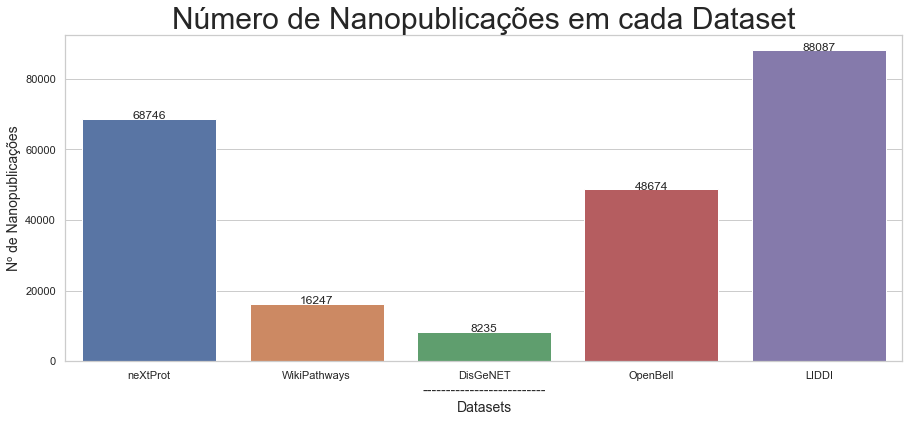

In [360]:
dataNP = pd.read_csv('totalNanopublications.csv')
sns.set(style="whitegrid")
#For bar plot use following line
ax = sns.barplot(x="DataSets", y="Count", data=dataNP)

#For boxplot use following line
#ax = sns.boxplot(x="DataSets", y="Count", data=dataNP, palette="Set3")

ax.axes.set_title("Número de Nanopublicações em cada Dataset",fontsize=30)
ax.axes.set_xlabel('--------------------------\nDatasets', fontsize=14)
ax.axes.set_ylabel('Nº de Nanopublicações', fontsize=14)

values=dataNP['Count'].values
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1, values[i],ha="center")
plt.savefig('NPxDataset.png')
plt.show()
